## Fourier extraction of the $m = 2$ component, linking to the bar strength

When examining the disk in a two-dimensional, face-on perspective, the ratio of surface brightness profiles is expressed as:

$$\frac{I(R, \phi)}{\bar{I}(R)} = 1 + \sum_{1}^{\infty} A_m(R) \cos{(m(\phi-\phi_m(R)))}$$

This formulation represents a Fourier decomposition of the observed brightness into its principal components. In our simulation, we employ the density profile, designed to accurately reproduce the observed brightness profile of an exponential disk.

For the specific computation of interest, we focus solely on extracting the $A_2$ amplitude parameter, which, in cumulative form, is given by [source](https://arxiv.org/abs/1705.02348):

$$A_2(<R) = \frac{|\sum_j m_j e^{2 i \theta_j}|}{\sum_j m_j}$$

It is crucial to note that "the summation is carried over all particles enclosed within a cylinder of radius R, coaxial with the galaxy." The angle of the bar at a given time $t$ is computed as:

$$\Phi(R) = \frac{1}{2} \arctan{\frac{\sum_j m_j \sin{(2\theta_j)}}{\sum_j m_j \cos{(2\theta_j)}}}$$

Other relevant quantities include the differential estimate of the $A_2$ parameter, providing insights into its radial profile extension. While this estimate is expected to exhibit the same behavior as the cumulative version, it is important to acknowledge that its implementation is influenced by the limited number of particles at higher radii, leading to a higher error in the estimate, as mentioned in the referenced article.

In [1]:
import numpy as np
import scipy
import math
import random
import pandas as pd
from matplotlib import animation

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from skspatial.objects import Sphere
from scipy.stats import uniform
import tqdm as tqdm

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Parameters from the run simulation

From the simulation carried out in the $\texttt{Nice_version_GALACTIC-BAR.ipynb}$ file, I only report the values I obtained and I set initially, to read the output file.

In [2]:
R_d = 1 #Scale radius
M = 1 #Total mass of the system
N = 20000 #Number of particles
G = 1 #Newton gravitation constant
m = M / N #The mass of a single particle
sigma_0 = M / (2 * np.pi * R_d**2) #The surface density

In [3]:
T = 16.016107920691983 # see previous notebook, as it changes every-time I set new parameters
print('Orbital period for R=R_d:', T)

Orbital period for R=R_d: 16.016107920691983


In [4]:
T_sim = 40 * T
print('Simulation time:', T_sim)

dt = T_sim / 1000
print('Time step:', dt)

theta = 0.2
print('Theta:', theta)

t_out = dt
print('Terminal out:', t_out)

Simulation time: 640.6443168276793
Time step: 0.6406443168276793
Theta: 0.2
Terminal out: 0.6406443168276793


# Data analysis

In [5]:
# reading the data from output-selected file

lines = pd.read_csv('outdata_expdisk_4.txt', names = list(range(3)), sep = '\s+')
N_particles = N
s = N*3+3

t_s  = np.array([lines.iloc[2::s,0].copy().dropna()]).flatten()
m_s  = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(3, N+3)])
x_s  = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(N+3, 2*N+3)])
y_s  = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(N+3, 2*N+3)])
z_s  = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(N+3, 2*N+3)])
vx_s = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(2*N+3, 3*N+3)])
vy_s = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(2*N+3, 3*N+3)])
vz_s = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(2*N+3, 3*N+3)])

### Initial and final frame

To see whether the disk is stable or not. It's my "passed or not passed test" to see whether the disk is actually still there after several orbital times.

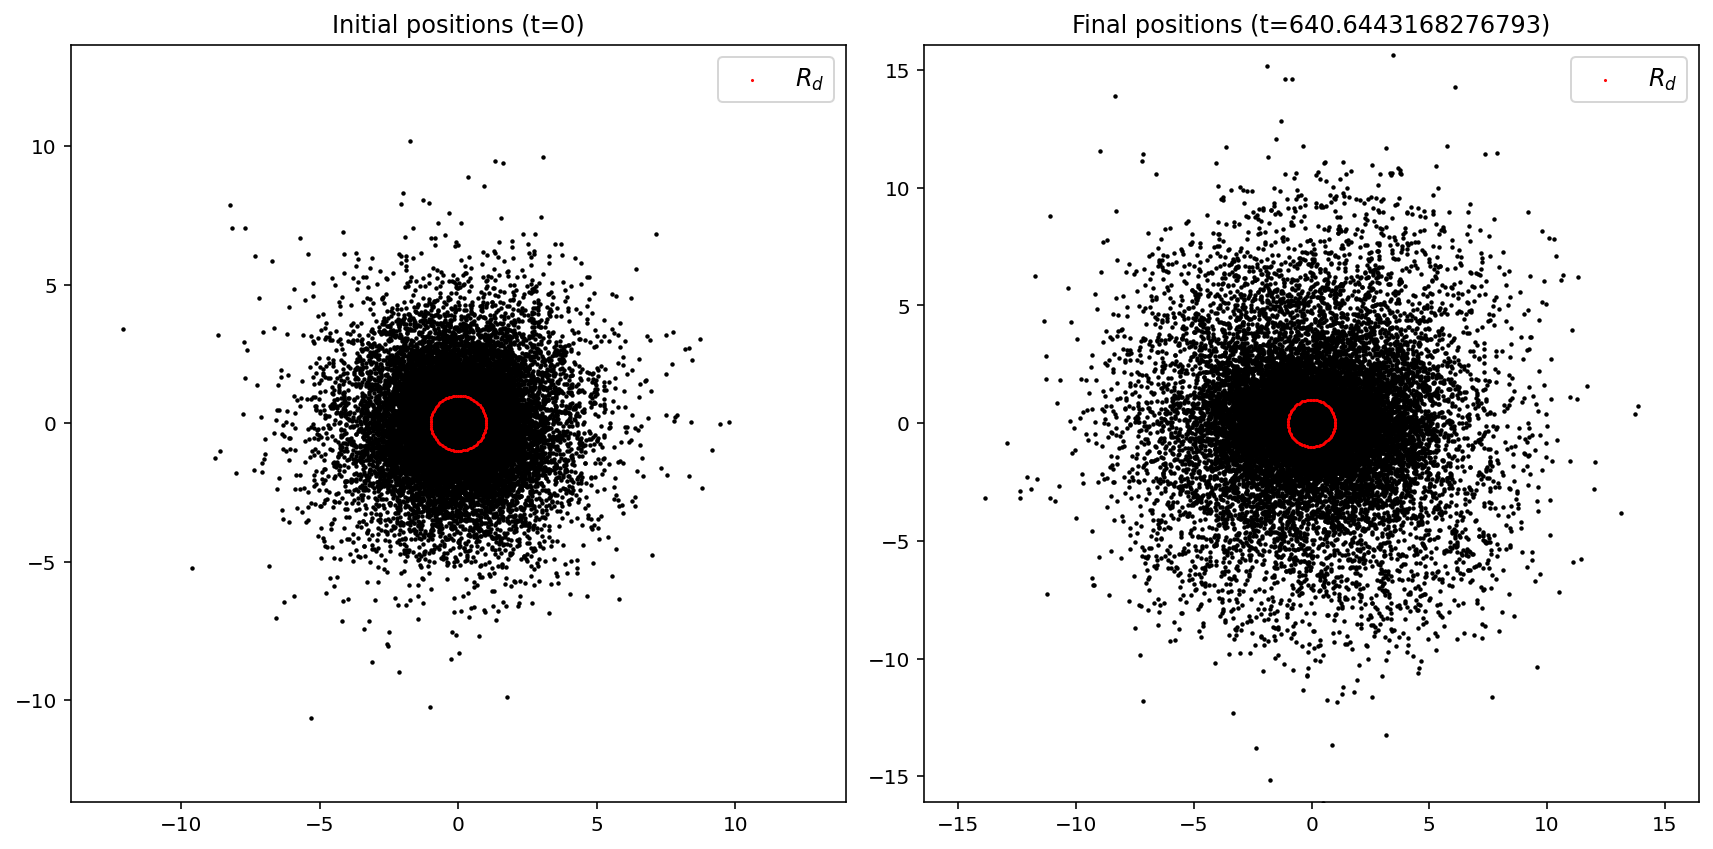

In [6]:
fig, ax = plt.subplots(1,2, tight_layout=True, figsize=(12, 6)) 

theta_Rd = np.linspace(0, 2*np.pi, 100)
R_rd = R_d
x1 = R_rd*np.cos(theta_Rd)
x2 = R_rd*np.sin(theta_Rd)

ax[0].scatter(x_s[:, 0], y_s[:, 0], c = 'black', alpha=1, s=1.5)
ax[0].set_title('Initial positions (t=0)')
ax[0].scatter(x1, x2, color='red',alpha=1, s=0.3, label='$R_d$')
ax[0].axis('equal')
ax[0].legend(fontsize='large')
ax[0].set_xlim(-15 * R_d, 15 * R_d)
ax[0].set_ylim(-15 * R_d, 15 * R_d);


ax[1].scatter(x_s[:, len(t_s)-1], y_s[:, len(t_s)-1], c = 'black', alpha=1, s=1.5)
ax[1].set_title(f'Final positions (t={T_sim})')
ax[1].scatter(x1, x2, color='red',alpha=1, s=0.3, label='$R_d$')
ax[1].axis('equal')
ax[1].legend(fontsize='large')
ax[1].set_xlim(-15 * R_d, 15 * R_d)
ax[1].set_ylim(-15 * R_d, 15 * R_d);

### Evolution frames of the system

We divide the time steps in 9 different frames we plot in the following configuration to also first estimate when the bar forms (veeery qualitative).

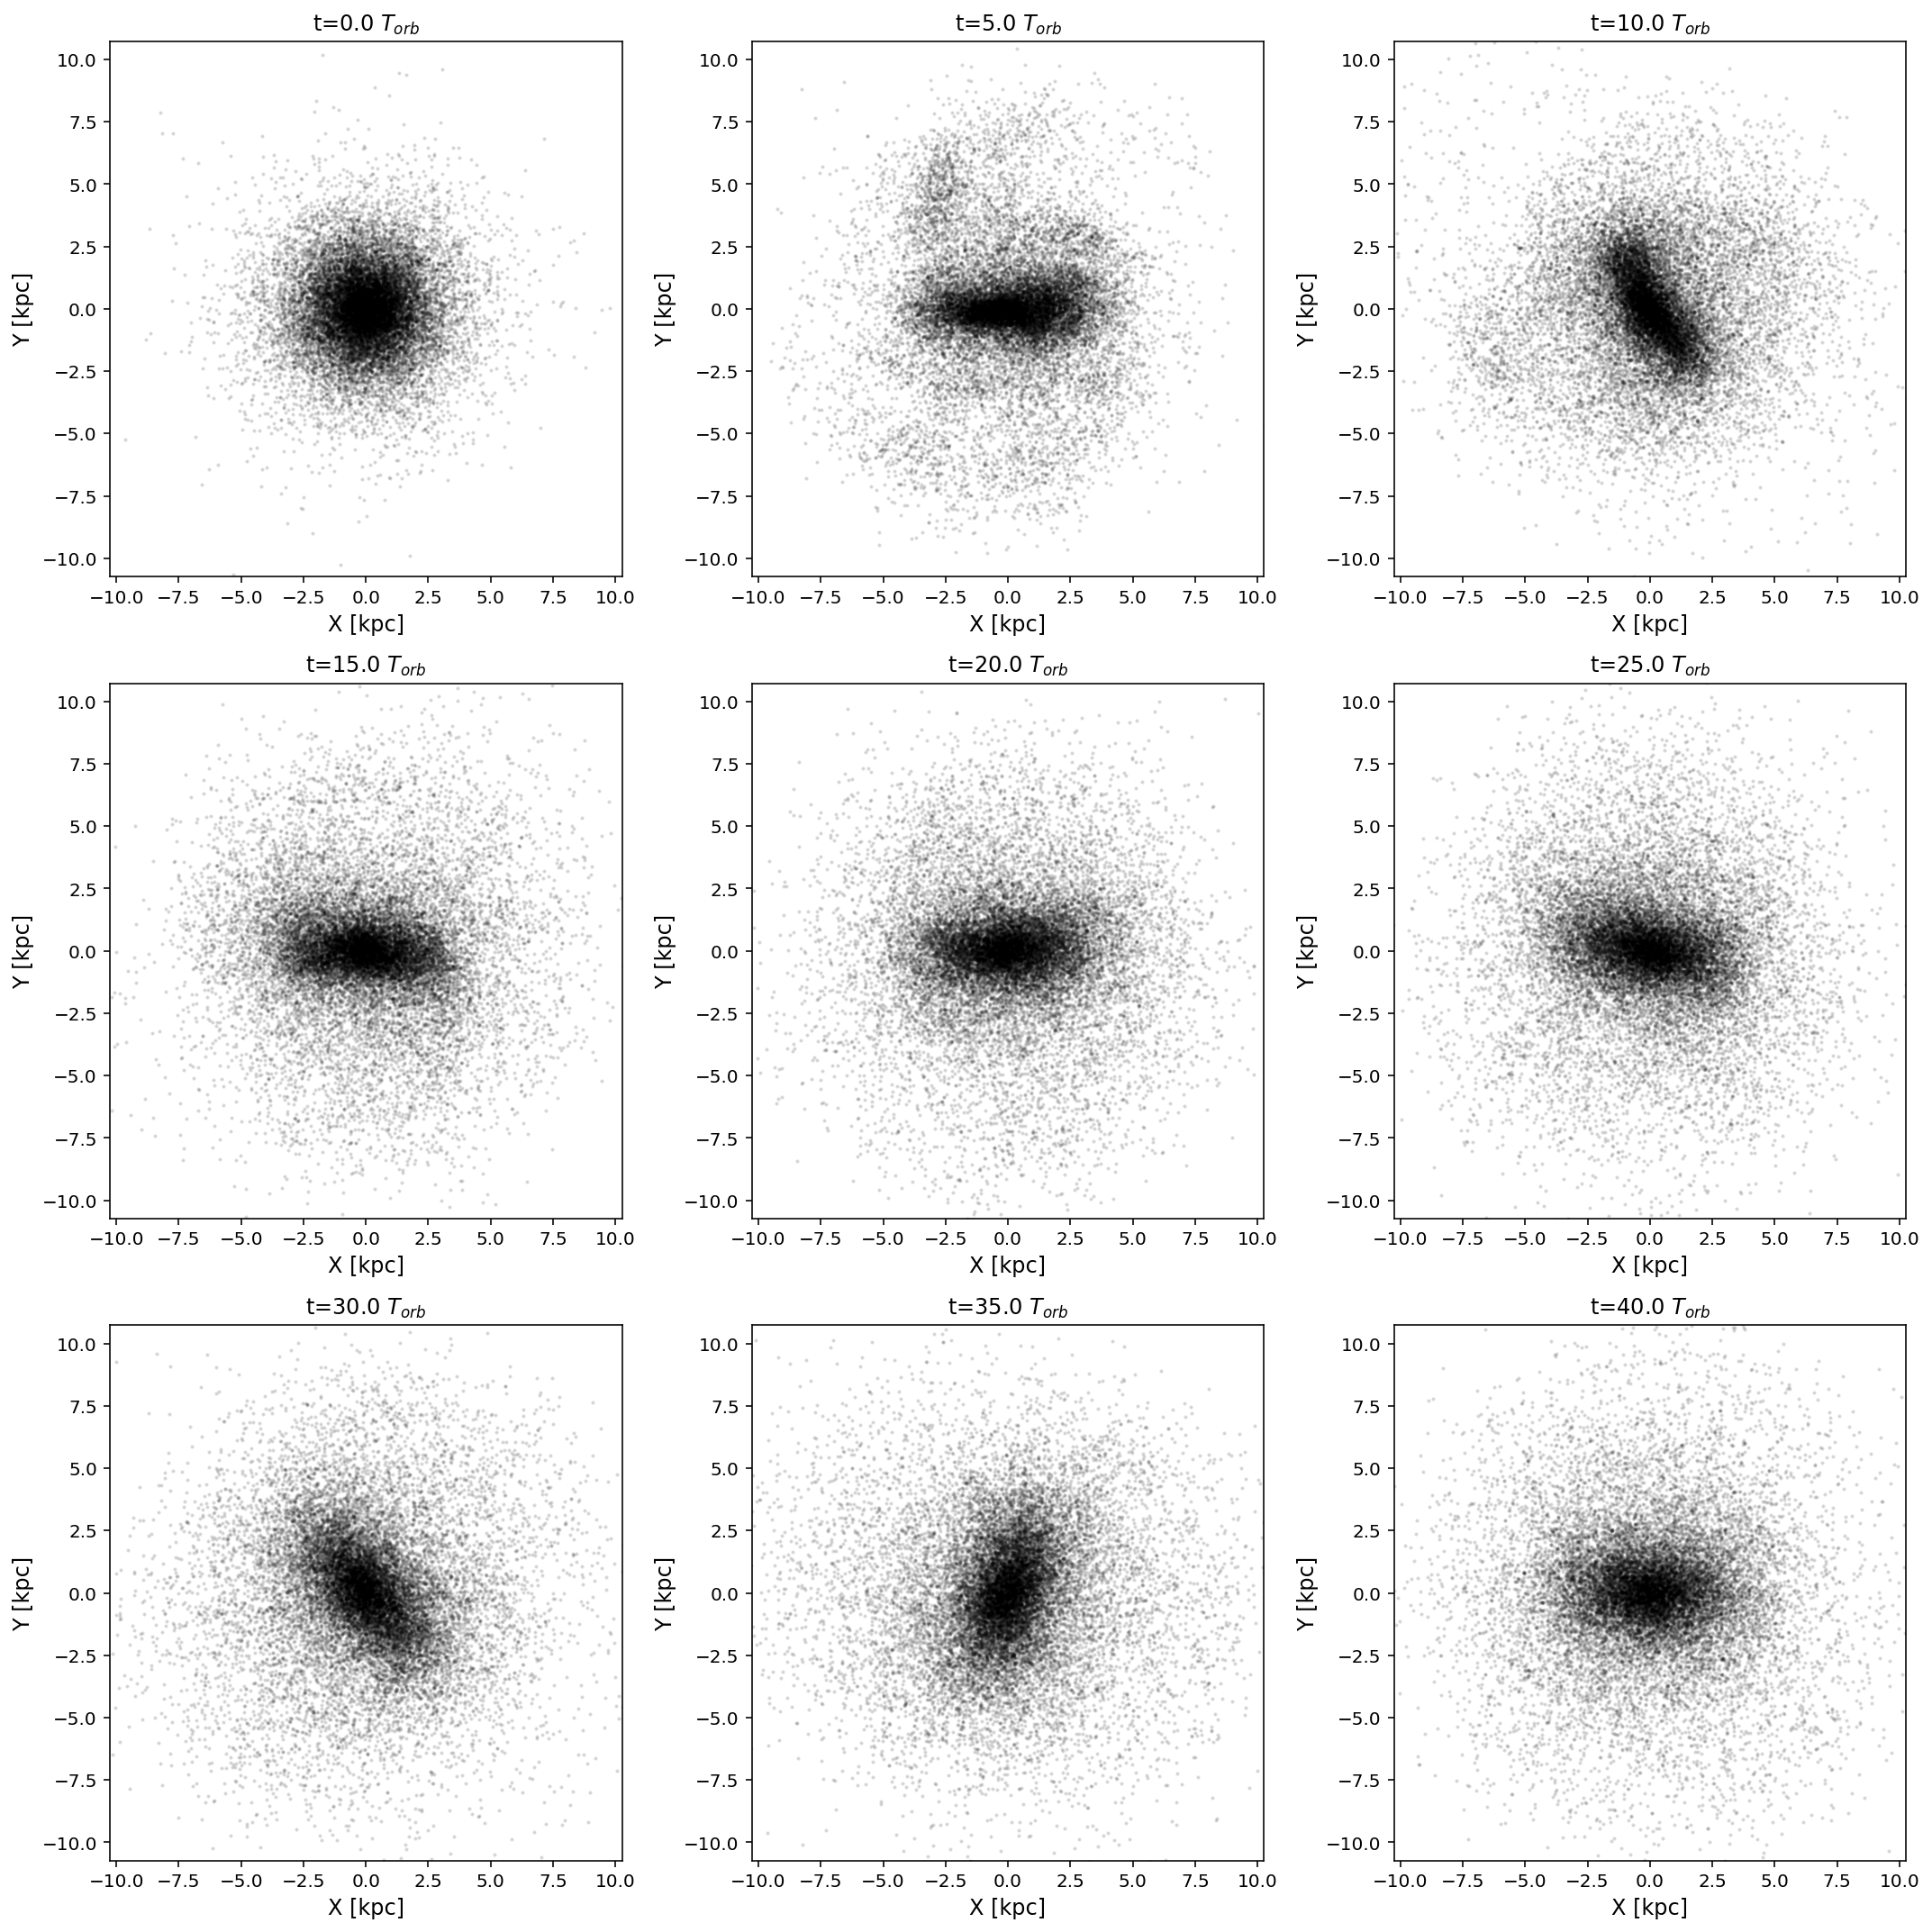

In [7]:
#Plot without the R_d parameter

fig = plt.figure(figsize=(15, 15), tight_layout=True)

l=10

index=1
time_array=np.linspace(0, len(t_s)-1, 9, dtype=int)

t_dyn_units = t_s/T

for i in time_array:
    ax=fig.add_subplot(3,3,index)
    plt.scatter(x_s[:, i], y_s[:, i], c='black', alpha=0.1, s=1.5)
    
    plt.title(r't=%.1f $T_{orb}$' %t_dyn_units[i])
    #plt.scatter(x1, x2, color='black',alpha=0.9, s=0.1, label='$R_d$')
    plt.axis('equal')
    plt.xlabel('X [kpc]', fontsize=12)
    plt.ylabel('Y [kpc]', fontsize=12)
    plt.xlim(-10 * R_d, 10 * R_d)
    plt.ylim(-10 * R_d, 10 * R_d)
    
    index +=1

plt.savefig('evolution_framework.pdf')
plt.show()

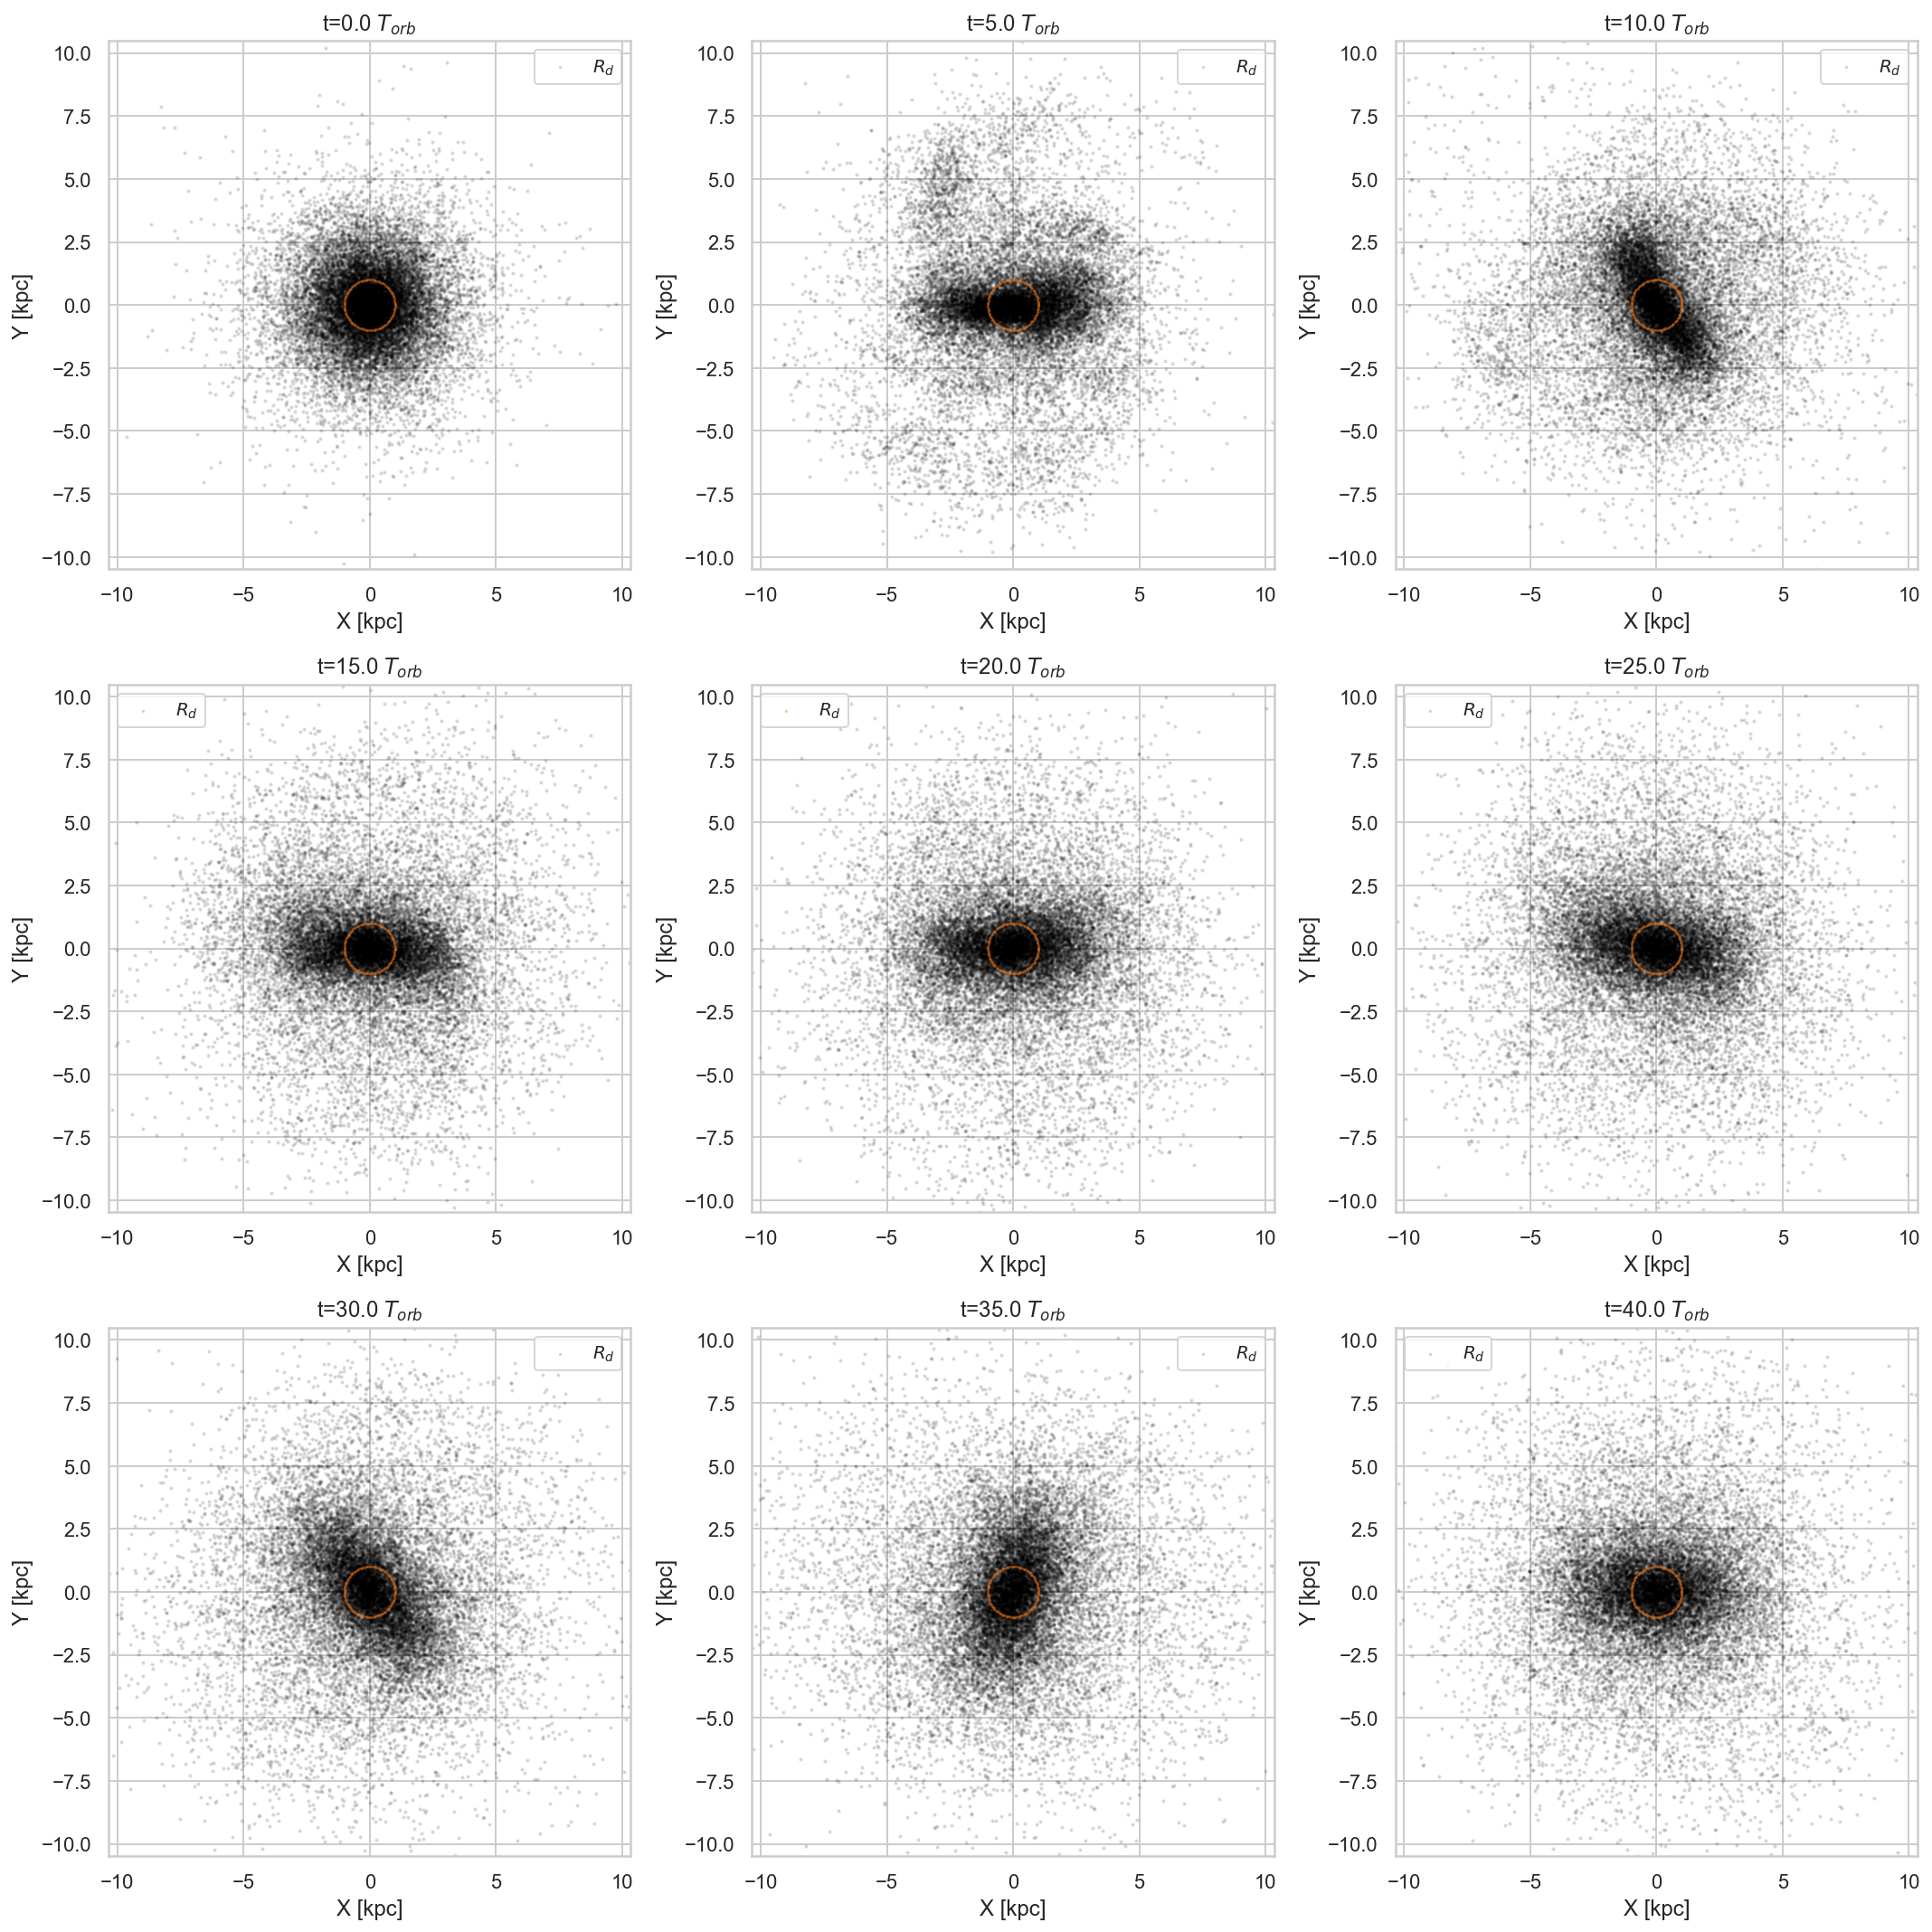

In [8]:
#Same plot, but showing the R_d distance from CM (I need it for the report)

fig = plt.figure(figsize=(15, 15), tight_layout=True)

l=10

index=1
time_array=np.linspace(0, len(t_s)-1, 9, dtype=int)

t_dyn_units = t_s/T

sns.set(style="whitegrid")

for i in time_array:
    ax=fig.add_subplot(3,3,index)
    plt.scatter(x_s[:, i], y_s[:, i], c='black', alpha=0.1, s=1.5)
    plt.scatter(x1, x2, color=plt.cm.inferno(0.7),alpha=0.35, s=0.5, label='$R_d$')
    
    plt.title(r't=%.1f $T_{orb}$' %t_dyn_units[i])
    #plt.scatter(x1, x2, color='black',alpha=0.9, s=0.1, label='$R_d$')
    plt.axis('equal')
    plt.xlabel('X [kpc]', fontsize=12)
    plt.ylabel('Y [kpc]', fontsize=12)
    plt.xlim(-10 * R_d, 10 * R_d)
    plt.ylim(-10 * R_d, 10 * R_d)
    plt.legend(fontsize='small')
    
    index +=1

plt.savefig('evolution_framework_with_rd.pdf')
plt.show()

### Lagrangian radii and CM motion

To further assess the stability of the system we work on the Lagrangian radii during the entire evolution of the system. We also evaluate the CM position at each time step.

In [9]:
R_t = np.zeros((N,len(t_s)))
radial_cm = []

for k in range(0,len(t_s)):
    
    x_cm_t = np.sum(x_s[:,k]) * m / M
    y_cm_t = np.sum(y_s[:,k]) * m / M
    z_cm_t = np.sum(z_s[:,k]) * m / M
    
    radial_cm.append([x_cm_t, y_cm_t])
    
    R_t[:,k] = np.sqrt((x_s[:,k] - x_cm_t)**2 + (y_s[:,k] - y_cm_t)**2 + (z_s[:,k] - z_cm_t)**2)
    
R_t.shape

(20000, 1001)

In [10]:
radial_cm = np.array(radial_cm)

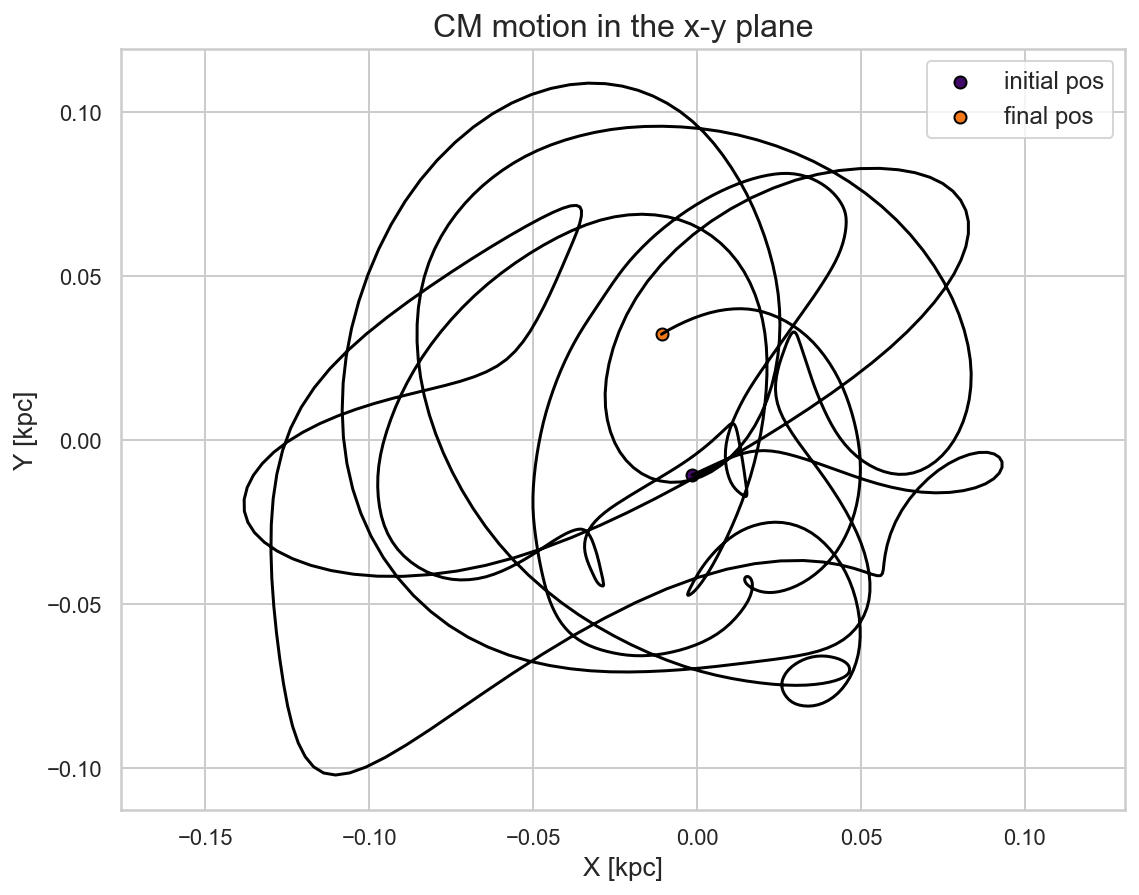

In [11]:
#Center of mass motion over time

sns.set(style="whitegrid")

plt.figure(figsize=(9, 7))
plt.plot(radial_cm.T[0], radial_cm.T[1], color='black')
plt.title('CM motion in the x-y plane', fontsize=16)
plt.xlabel('X [kpc]', fontsize=13)
plt.ylabel('Y [kpc]', fontsize=13)
plt.scatter(radial_cm.T[0][0], radial_cm.T[1][0], label='initial pos', color=plt.cm.inferno(0.2), edgecolor='black')
plt.scatter(radial_cm.T[0][-1], radial_cm.T[1][-1], label='final pos', color=plt.cm.inferno(0.7), edgecolor='black')
plt.legend(fontsize='medium', loc='upper right')
plt.axis('equal')
plt.savefig('cm_motion.pdf');

In [12]:
lag_80 = []
lag_60 = []
lag_50 = []
lag_10 = []

for i in range(len(t_s)):
    r_sort = R_t[:,i]

    lag_80.append(np.max(r_sort[r_sort < np.quantile(r_sort, 0.8)]))
    lag_60.append(np.max(r_sort[r_sort < np.quantile(r_sort, 0.6)]))
    lag_50.append(np.max(r_sort[r_sort < np.quantile(r_sort, 0.5)]))
    lag_10.append(np.max(r_sort[r_sort < np.quantile(r_sort, 0.1)]))

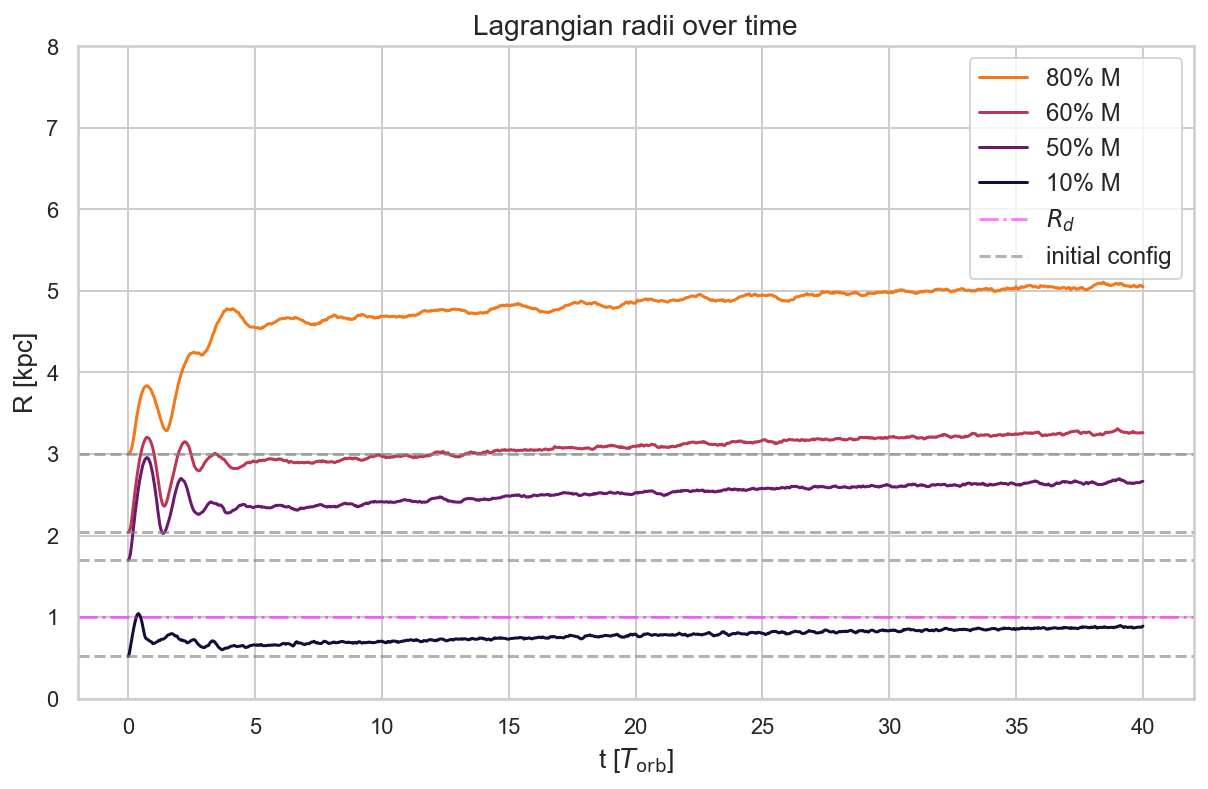

In [13]:
#lagrangian radii
#%matplotlib inline

plt.figure(figsize=(10, 6))

sns.lineplot(x=t_s/T, y=lag_80, label="80% M", alpha=1, color=plt.cm.inferno(0.7))
sns.lineplot(x=t_s/T, y=lag_60, label="60% M", alpha=1, color=plt.cm.inferno(0.5))
sns.lineplot(x=t_s/T, y=lag_50, label="50% M", alpha=1, color=plt.cm.inferno(0.3))
sns.lineplot(x=t_s/T, y=lag_10, label="10% M", alpha=1, color=plt.cm.inferno(0.1))

plt.axhline(R_d, color='magenta', linestyle='-.', label='$R_d$', alpha=0.5)

plt.axhline(lag_80[0], color='gray', linestyle='dashed', alpha=0.6, label='initial config')
plt.axhline(lag_60[0], color='gray', linestyle='dashed', alpha=0.6)
plt.axhline(lag_50[0], color='gray', linestyle='dashed', alpha=0.6)
plt.axhline(lag_10[0], color='gray', linestyle='dashed', alpha=0.6)

plt.xlabel("t [$T_{\mathrm{orb}}$]", fontsize=13)
plt.ylabel("R [kpc]", fontsize=13)
plt.title("Lagrangian radii over time", fontsize=14)
plt.legend(fontsize='medium')
plt.ylim(0, 8 * R_d)
plt.savefig('lagrangian-radii.pdf');

## Extracting the $A_2$ parameter:

We need to assess the angles at a fixed frame:

In [14]:
def find_angle(x, y): 
    
    return np.arctan2(y, x)

In this case I only fix a time frame, and see if it works:

In [15]:
time_frame = time_array[4]

In [16]:
theta_j = find_angle(x_s[:, time_frame], y_s[:, time_frame])

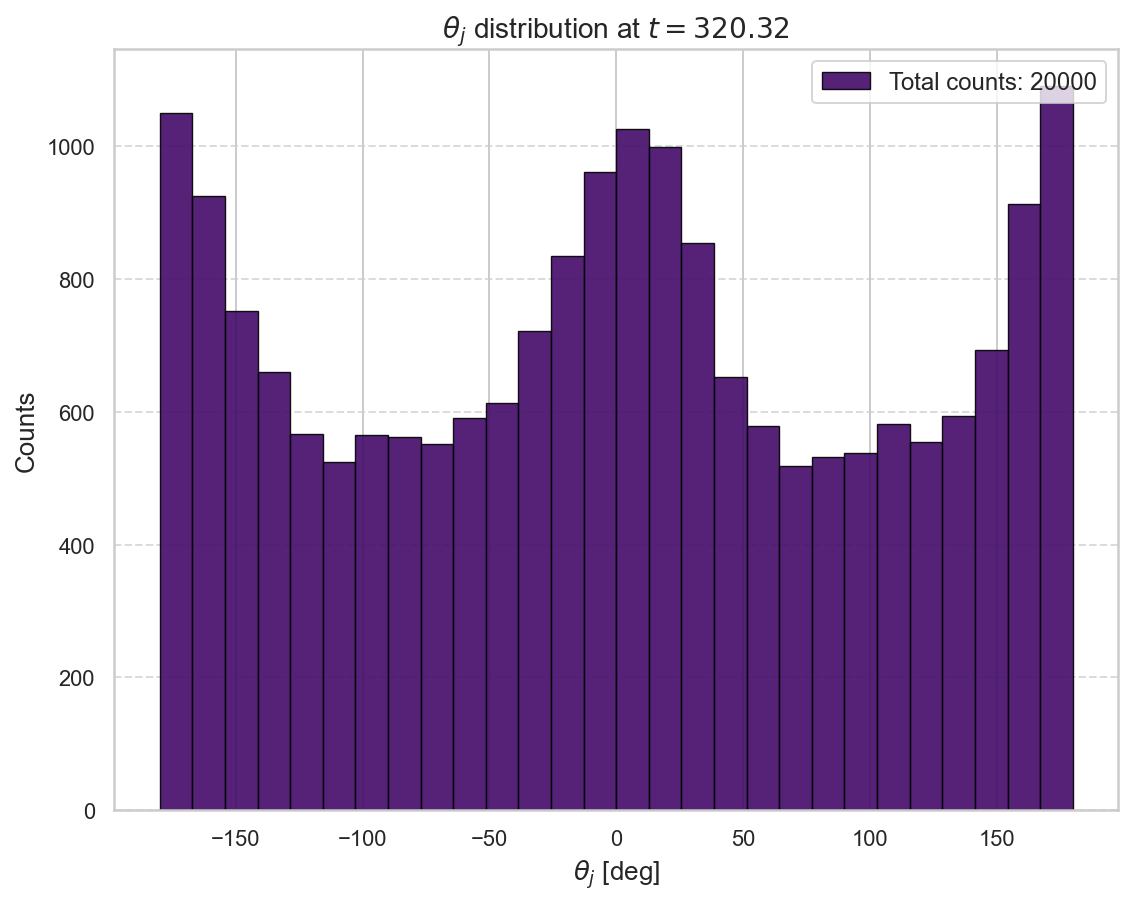

In [17]:
plt.figure(figsize=(9, 7))

# Use 'auto' option for bins to automatically determine the number of bins
plt.hist(theta_j * 180 / np.pi, bins='auto', color=plt.cm.inferno(0.2), alpha=0.9, edgecolor='black', linewidth=0.7)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xlabel(r'$\theta_j$ [deg]', fontsize=13)
plt.ylabel('Counts', fontsize=13)

# Adjust the title for better spacing
plt.title(rf'$\theta_j$ distribution at $t={t_s[time_frame]:.2f}$', fontsize=14)

# Add a legend with the number of counts
counts = len(theta_j)
plt.legend([f'Total counts: {counts}'], loc='upper right', fontsize='medium')

plt.show()

It seems to work! Good... Let's now see whether the calculation of the cumulative $A_2(<R)$ value works as well at a fixed position $R_d$.

In [18]:
x_cm = np.sum(x_s[:, time_frame]) * m / M
y_cm = np.sum(y_s[:, time_frame]) * m / M

R_j = np.sqrt((x_s[:, time_frame] - x_cm)**2 + (y_s[:, time_frame] - y_cm)**2)

In [19]:
def find_A2_j(R, R_max, ms, thetas): 
    
    mask = (R < R_max)
    
    return np.abs(np.sum(ms[mask] * np.exp(2j * theta_j[mask]))) / np.sum(ms[mask])

In [20]:
cum_a2 = find_A2_j(R_j, R_d, m_s[:, time_frame], theta_j)

In [21]:
print(f'Cumulative a2 at time {t_s[time_frame] / T} T, at distance R={R_d}:', cum_a2)

Cumulative a2 at time 20.000040683177435 T, R=1: 0.07107636187165663


### The evolution in time at a fixed position ($2R_d$):

---

This part only serves as some check to me to see the arrays have the right sizes.

In [22]:
theta_j_t = np.array([find_angle(x_s[:, i], y_s[:, i]) for i in range(0, len(t_s))]).T
theta_j_t.shape

(20000, 1001)

In [23]:
R_max = np.linspace(0.5 * R_d, 7.5 * R_d)

In [24]:
# Initialize arrays to store results
x_cm_t = np.zeros_like(t_s)
y_cm_t = np.zeros_like(t_s)
R_j_t = np.zeros((len(x_s), len(t_s)))

# Calculate x_cm_t and y_cm_t at each time frame
for i in range(len(t_s)):
    x_cm_t[i] = np.sum(x_s[:, i] * m_s[:, i]) / np.sum(m_s[:, i])
    y_cm_t[i] = np.sum(y_s[:, i] * m_s[:, i]) / np.sum(m_s[:, i])

# Calculate R_j_t for each particle at each time frame
for i in range(len(t_s)):
    
    R_j_t[:, i] = np.sqrt((x_s[:, i] - x_cm_t[i])**2 + (y_s[:, i] - y_cm_t[i])**2)

In [25]:
R_j_t.shape

(20000, 1001)

In [26]:
x_j = R_j_t * np.cos(theta_j_t)
y_j = R_j_t * np.sin(theta_j_t)

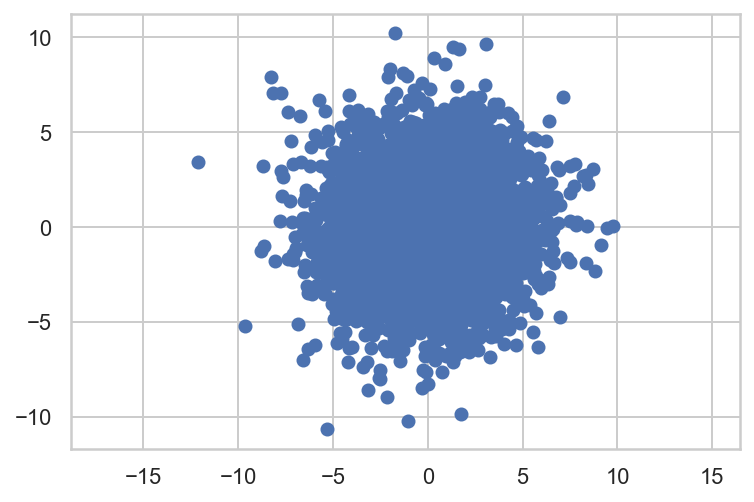

In [27]:
plt.scatter(x_j[:, 0], y_j[:, 0])
plt.axis('equal');

---

In [28]:
def find_A2_t(ts, R_t, R_max, ms, theta_j): 
    
    '''This function finds the value of A_2(<R) over time, for all times in the 
    evolution of the system, fixing a position in space.'''
    
    a2_t = []
    
    for i in range(0, len(ts)):
    
        mask = (R_j_t[:, i] < R_max)
        a2_t.append(np.abs(np.sum(ms[:, i][mask] * np.exp(2j * theta_j[:, i][mask]))) / np.sum(ms[:, i][mask]))
    
    return np.array(a2_t)

In [65]:
a2_t = find_A2_t(t_s, R_j_t, 1 * R_d, m_s, theta_j_t)

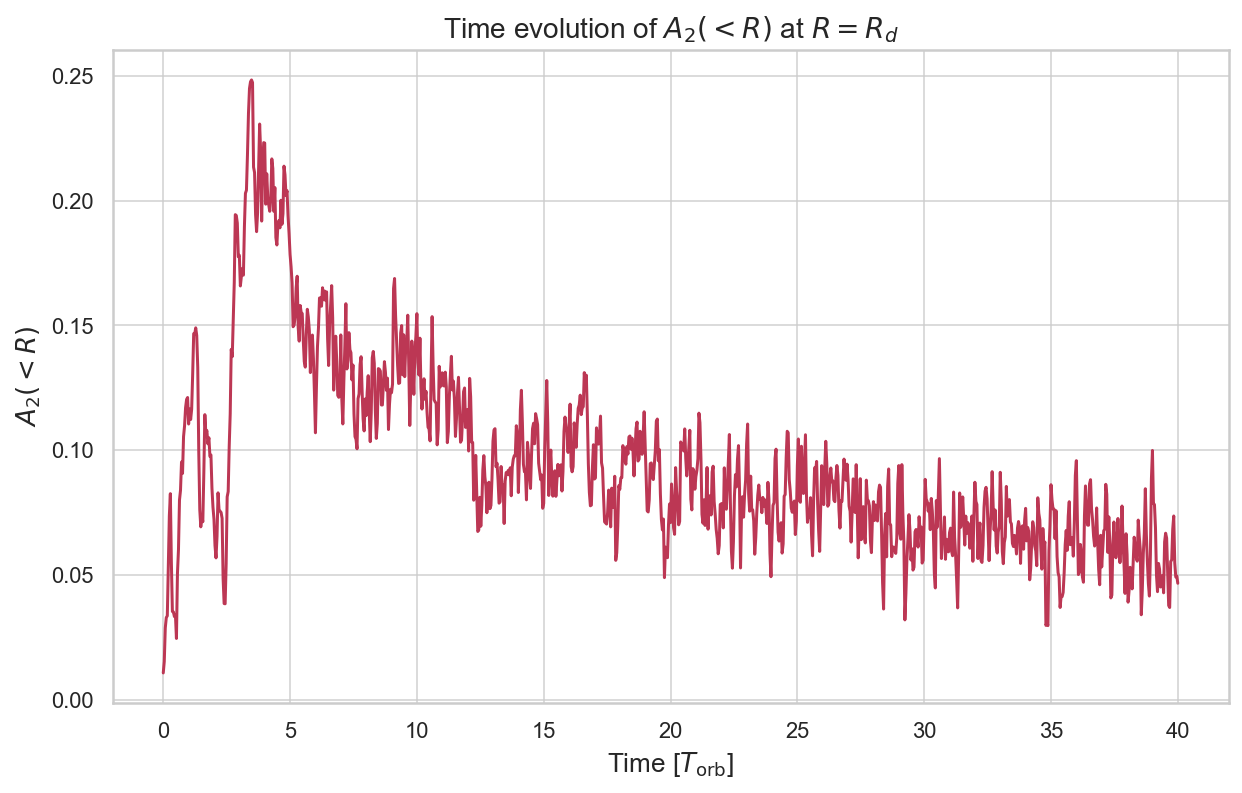

In [67]:
# Set Seaborn style
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.lineplot(x=t_s/T, y=a2_t, color=plt.cm.inferno(0.5), linewidth=1.5)

# Add grid lines for better readability
plt.grid(axis='both', linestyle='-', alpha=0.7)

plt.xlabel('Time [$T_{\mathrm{orb}}$]', fontsize=13)
plt.ylabel('$A_2(<R)$', fontsize=13)
plt.title(rf'Time evolution of $A_2(<R)$ at $R=R_d$', fontsize=14)

# Add legend for better identification of the curve
#plt.legend(fontsize='large', loc='upper right')
plt.savefig('evolution-a2-time.pdf')
plt.show()

### The cumulative at a fixed time frame $t_i$:

In [31]:
def find_A2_r(time_frame, R_j, R_max, ms, theta_j): 
    
    '''This function finds the radial dependence of A_2(<R), fixing a time in the evolution.'''
    
    a2_r = []
    
    for i in range(0, len(R_max)):
    
        mask = (R_j[:, time_frame] <= R_max[i])
        a2_r.append(np.abs(np.sum(ms[:, time_frame][mask] * np.exp(2j * theta_j[:, time_frame][mask]))) / np.sum(ms[:, time_frame][mask]))
    
    return np.array(a2_r)

In [32]:
step = R_max[1] - R_max[0]

In [33]:
a2_r = find_A2_r(time_array, R_j_t, R_max, m_s, theta_j_t)

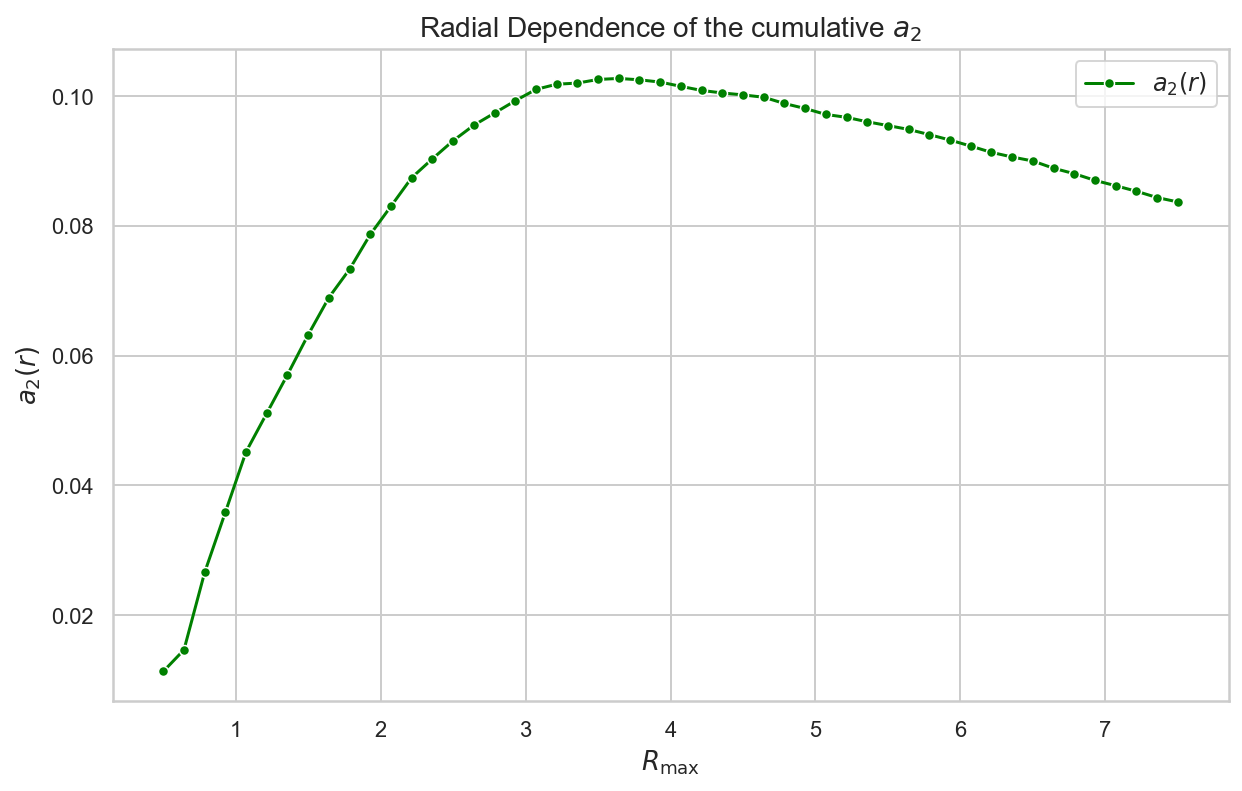

In [34]:
# Set Seaborn style
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

# Omit the first element since it might be an outlier
sns.lineplot(x=R_max, y=a2_r, color='green', linewidth=1.5, marker='o', markersize=5, label='$a_2(r)$')

plt.xlabel('$R_{\max}$', fontsize=13)
plt.ylabel('$a_2(r)$', fontsize=13)
plt.title('Radial Dependence of the cumulative $a_2$', fontsize=14)

# Add legend for better identification of the curve
plt.legend(fontsize='medium', loc='upper right')

plt.show()

Let's get the things more interesting evaluating this $A_2$ cumulative in different time frames:

In [35]:
R_j_t_selected = R_j_t[:, time_array]
theta_j_t_selected = theta_j_t[:, time_array]
m_s_selected = m_s[:, time_array]

In [36]:
a2_r_t = []

for i in range(0, len(time_array)):

    # time_array, R_j_t, R_max, m_s, theta_j_t
    a2_r_t.append(find_A2_r(i, R_j_t_selected, R_max, m_s_selected, theta_j_t_selected))

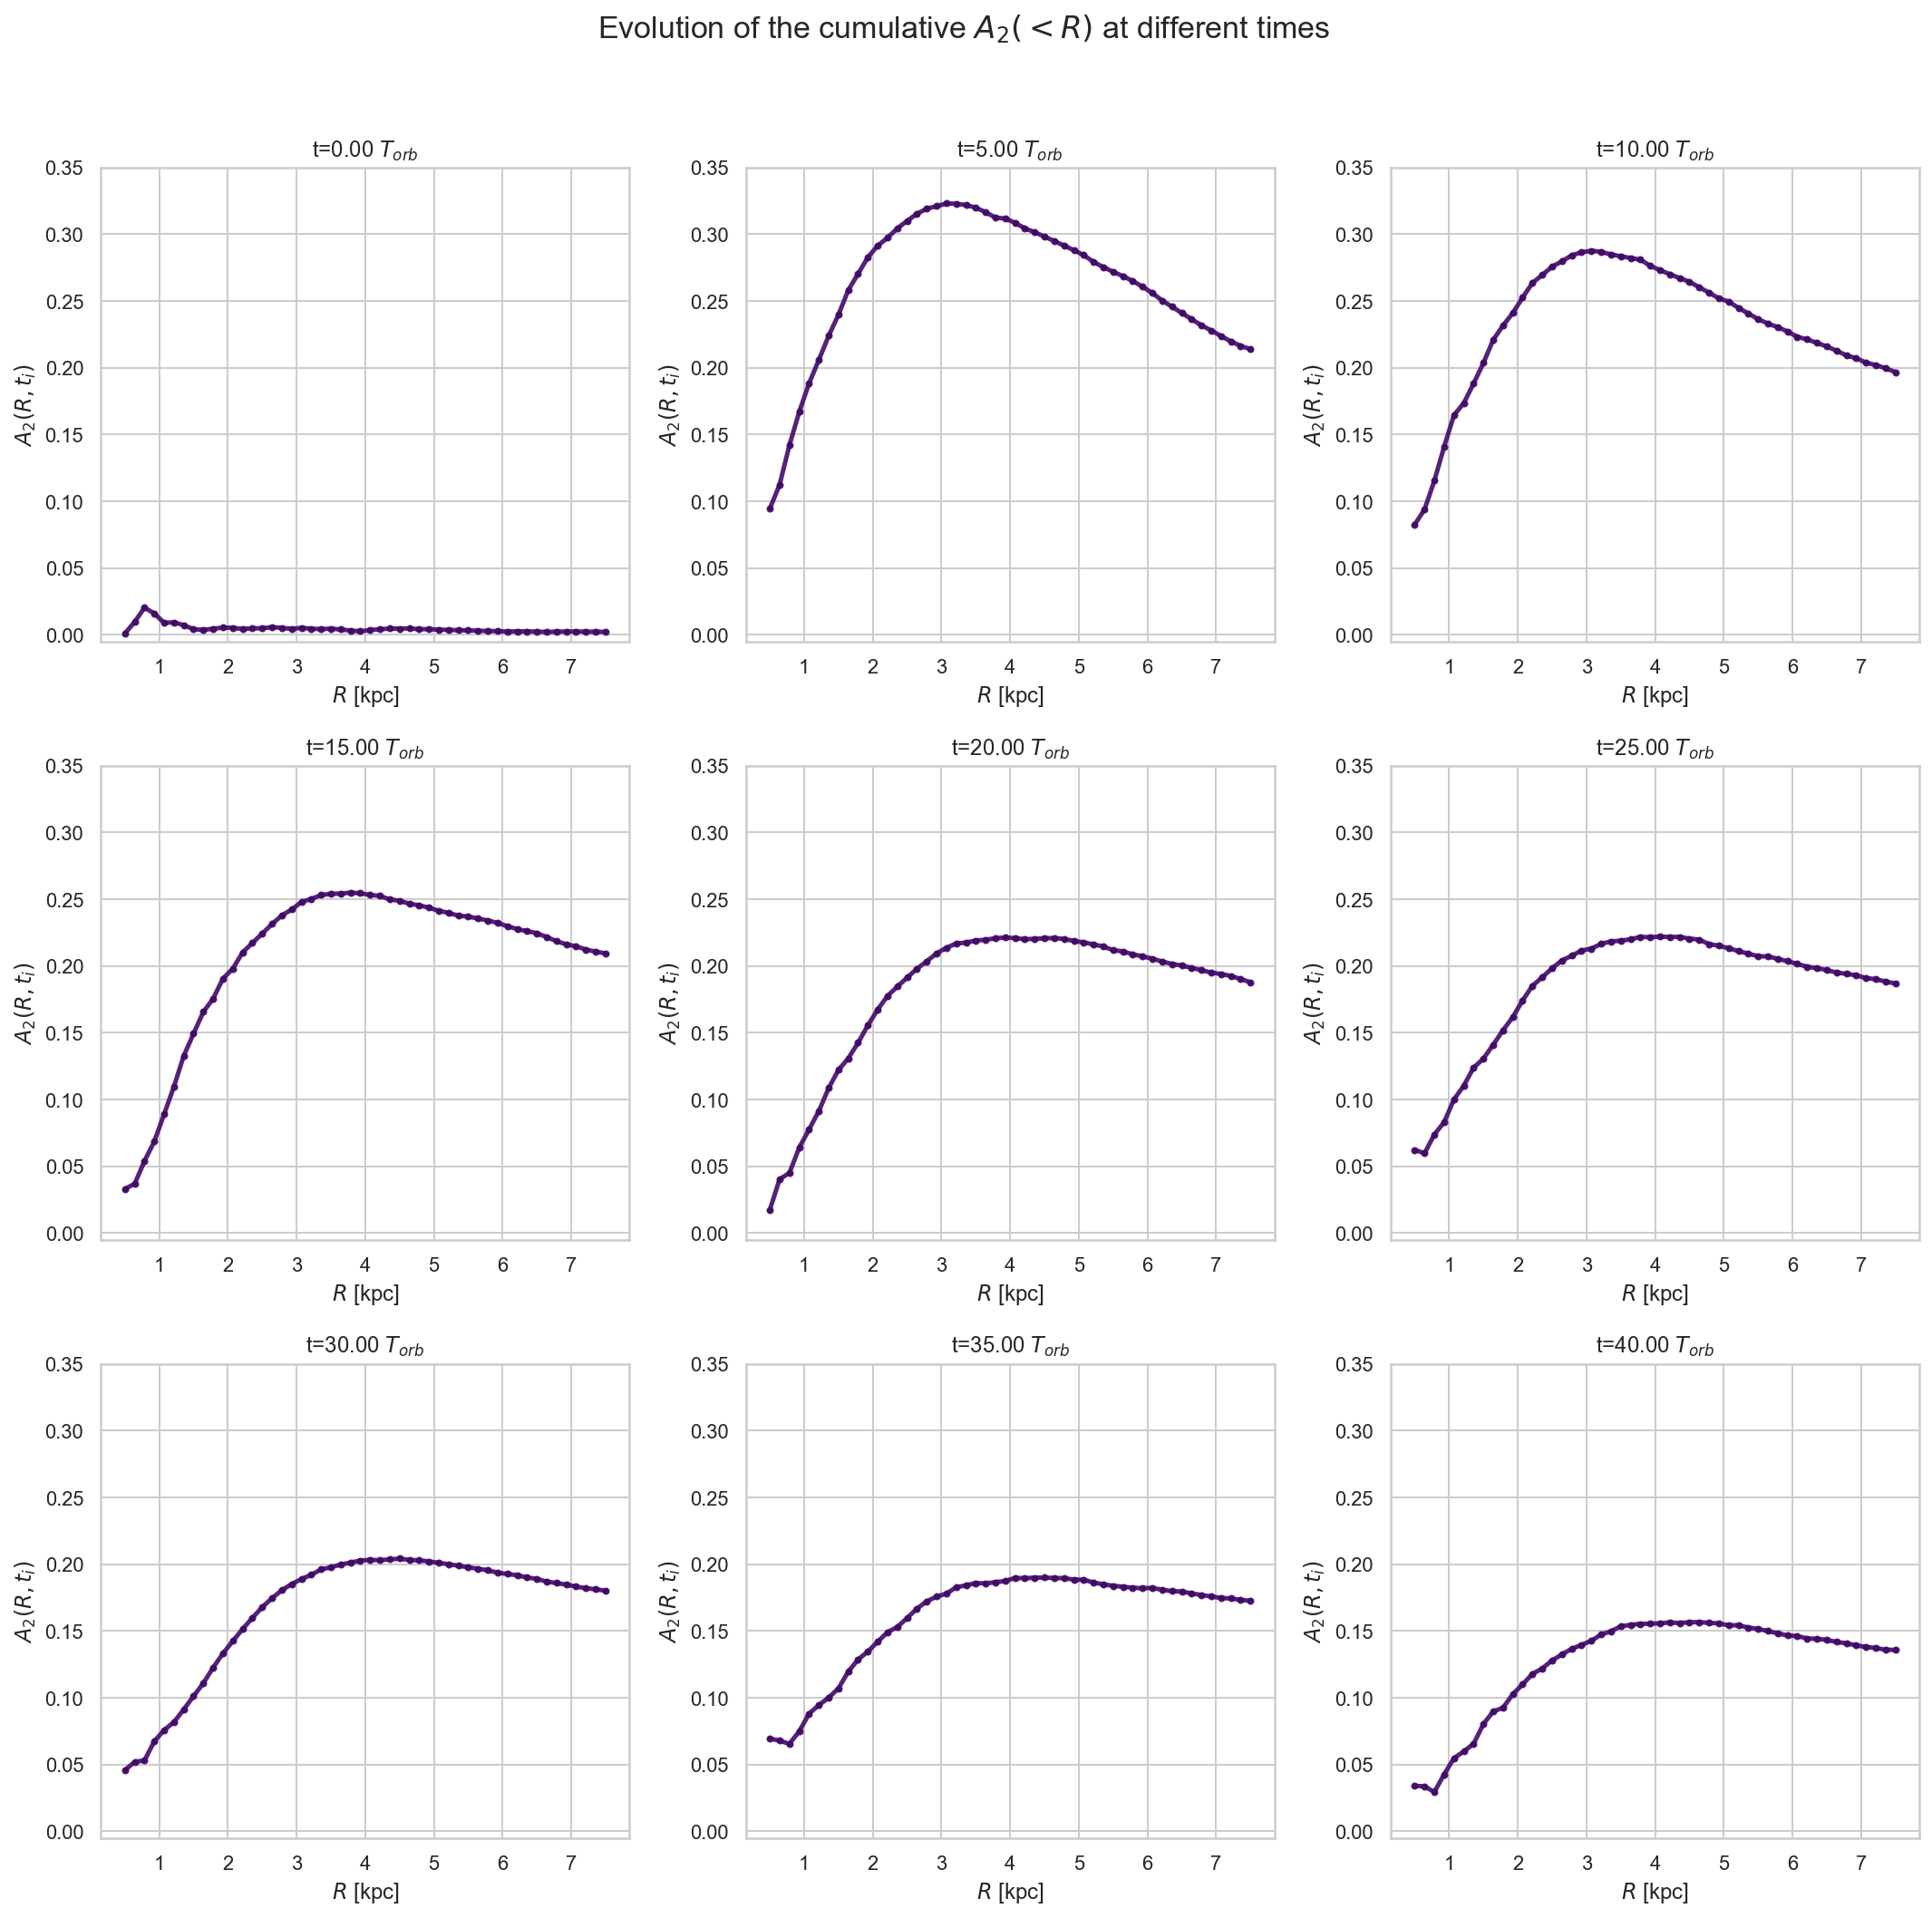

In [54]:
# Set Seaborn style
sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 3, figsize=(15, 15), tight_layout=True)

l = 10
time_array = np.linspace(0, len(t_s) - 1, 9, dtype=int)

t_dyn_units = t_s / T

for i, ax in zip(range(0, len(time_array)), axes.flatten()):
    ax.plot(R_max, a2_r_t[i], color=plt.cm.inferno(0.2), linewidth=2.5, marker='o', markersize=3, alpha=0.9)
    
    ax.set_title(f't={(t_s[time_array[i]] / T):.2f} $T_{{orb}}$')
    ax.set_xlabel('$R$ [kpc]')
    ax.set_ylabel('$A_2(R, t_i)$')
    ax.set_ylim(-0.005, 0.35)

# Adjust layout and add a title
fig.suptitle('Evolution of the cumulative $A_2(<R)$ at different times', fontsize=17)

# Adjust spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

### The coefficient for each R-anulus

In the article they show: 

"The result of the differential Fourier analysis, where we first divide the disc into annuli of equal width, and then we compute the value of
the ratio A2(R) separately for each annulus at radius R". I first write the function I need to do such a thing.

In [38]:
def find_A2_r_differential(time_frame, R_j, R_max, ms, theta_j): 
    
    '''This function finds the radial dependence of A_2(R), fixing a time in the evolution.'''
    
    a2_r = []
    
    for i in range(1, len(R_max)):
    
        mask = ((R_j[:, time_frame] <= R_max[i])&(R_j[:, time_frame] > R_max[i-1]))
        a2_r.append(np.abs(np.sum(ms[mask, time_frame] * np.exp(2j * theta_j[:, time_frame][mask]))) / np.sum(ms[:, time_frame][mask]))
        
    return np.array(a2_r)

In [39]:
a2_r_t_diff = []

for i in range(0, len(time_array)):

    a2_r_t_diff.append(find_A2_r_differential(i, R_j_t_selected, R_max, m_s_selected, theta_j_t_selected))

I here plot both the found cumulative $A_2(<R)$, and differential $A_2(R)$, to compare them:

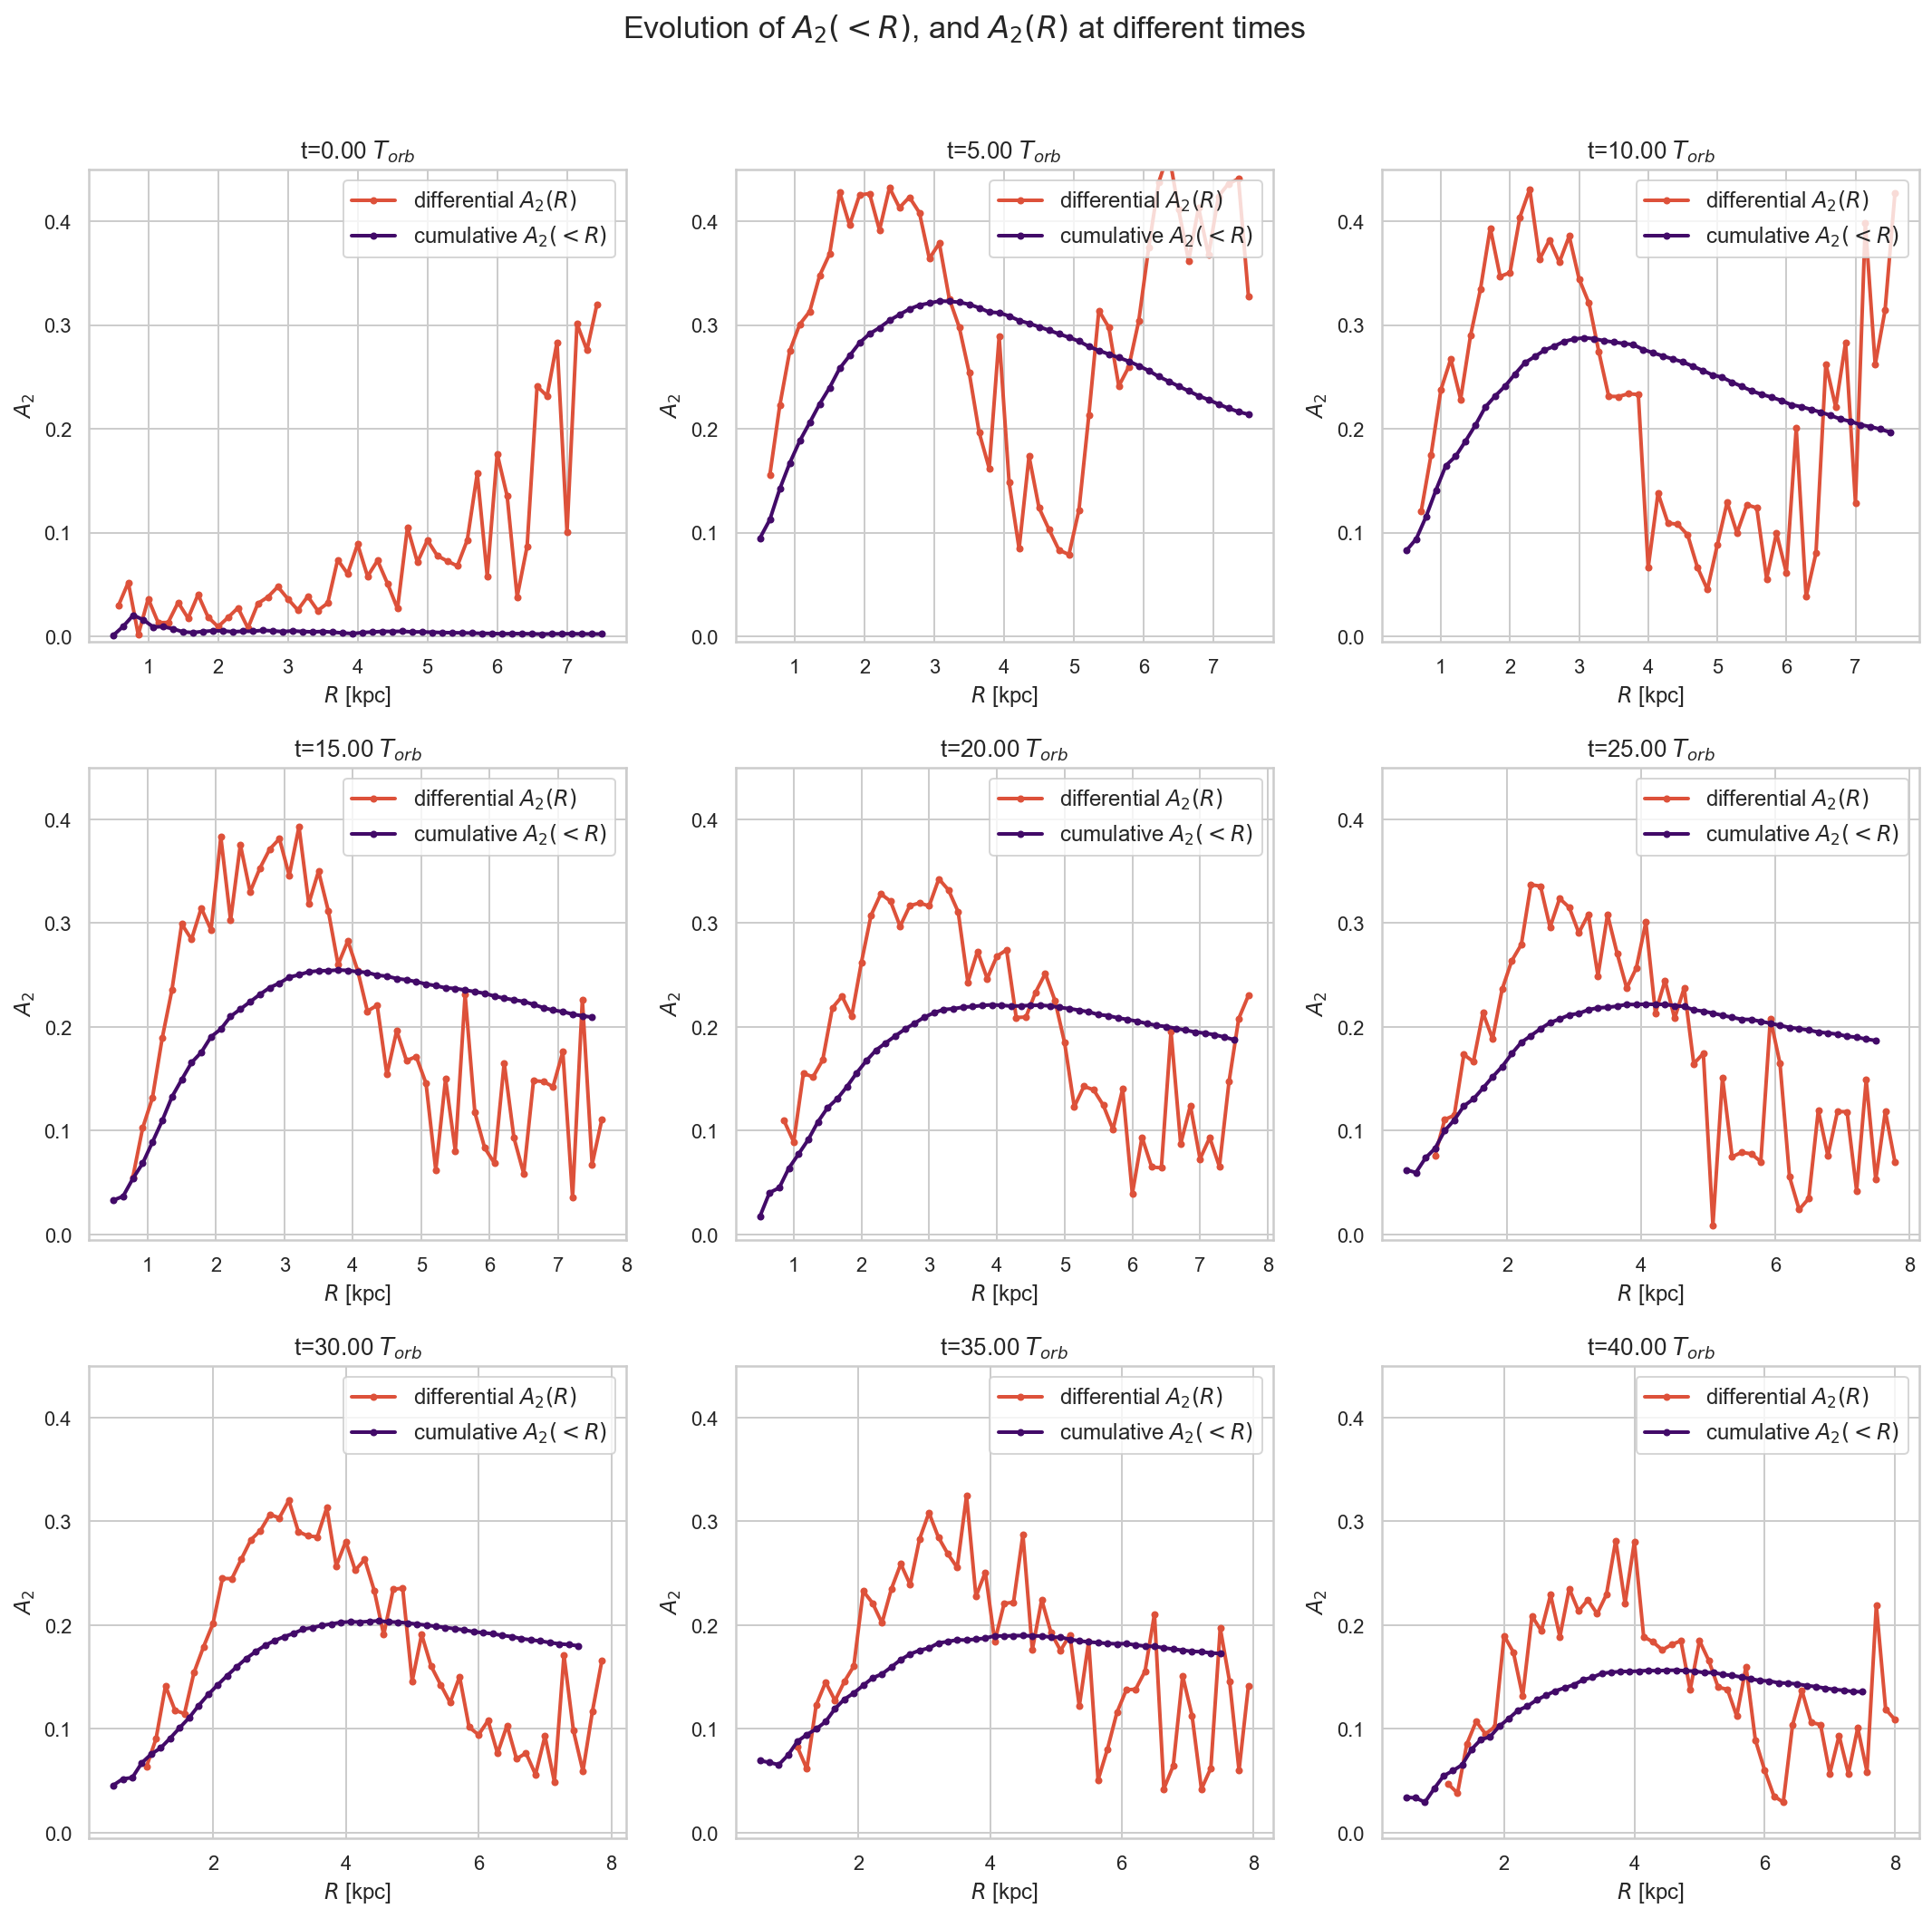

In [40]:
# Set Seaborn style
sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 3, figsize=(15, 15), tight_layout=True)

l = 10
time_array = np.linspace(0, len(t_s) - 1, 9, dtype=int)

t_dyn_units = t_s / T

for i, ax in zip(range(0, len(time_array)), axes.flatten()):
    ax.plot((R_max + (i+1) * step/2)[:-1], a2_r_t_diff[i], color=plt.cm.inferno(0.6), linewidth=2, marker='o', markersize=3, label='differential $A_2(R)$')
    ax.plot(R_max, a2_r_t[i], color=plt.cm.inferno(0.2), linewidth=2, marker='o', markersize=3, label='cumulative $A_2(<R)$')
    
    ax.set_title(f't={(t_s[time_array[i]] / T):.2f} $T_{{orb}}$', fontsize=13)
    ax.set_xlabel('$R$ [kpc]', fontsize=12)
    ax.set_ylabel('$A_2$', fontsize=12)
    ax.legend(loc='upper right', fontsize='medium')
    ax.set_ylim(-0.005, 0.45)

# Adjust layout and add a title
fig.suptitle('Evolution of $A_2(<R)$, and $A_2(R)$ at different times', fontsize=17)

# Adjust spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('evolution-a2-a2.pdf')
plt.show()

Does this make sense? Check with professor!

### Angle and bar width:

In [41]:
def phi_bar_r(time_frame, R_j, R_max, ms, theta_j): 
    
    '''This function finds the radial dependence of Phi(R), fixing a time in the evolution.'''
    
    phi_t = []
    
    for i in range(0, len(R_max)-1):
        
        mask = ((R_j_t[:, time_frame] < R_max[i+1])&(R_j_t[:, time_frame] > R_max[i]))
        phi_t.append(0.5 * np.arctan(np.sum(ms[mask] * np.cos(2 * theta_j[mask]))/np.sum(ms[mask] * np.sin(2 * theta_j[mask]))))
    
    return phi_t

Find the differential dependency on $R$ of $\Phi(R)$ at a fixed time frame:

In [42]:
phi_r_t_diff = []

for i in range(0, len(time_array)):

    phi_r_t_diff.append(phi_bar_r(i, R_j_t_selected[:, i], R_max, m_s[:, i], theta_j_t_selected[:, i]))

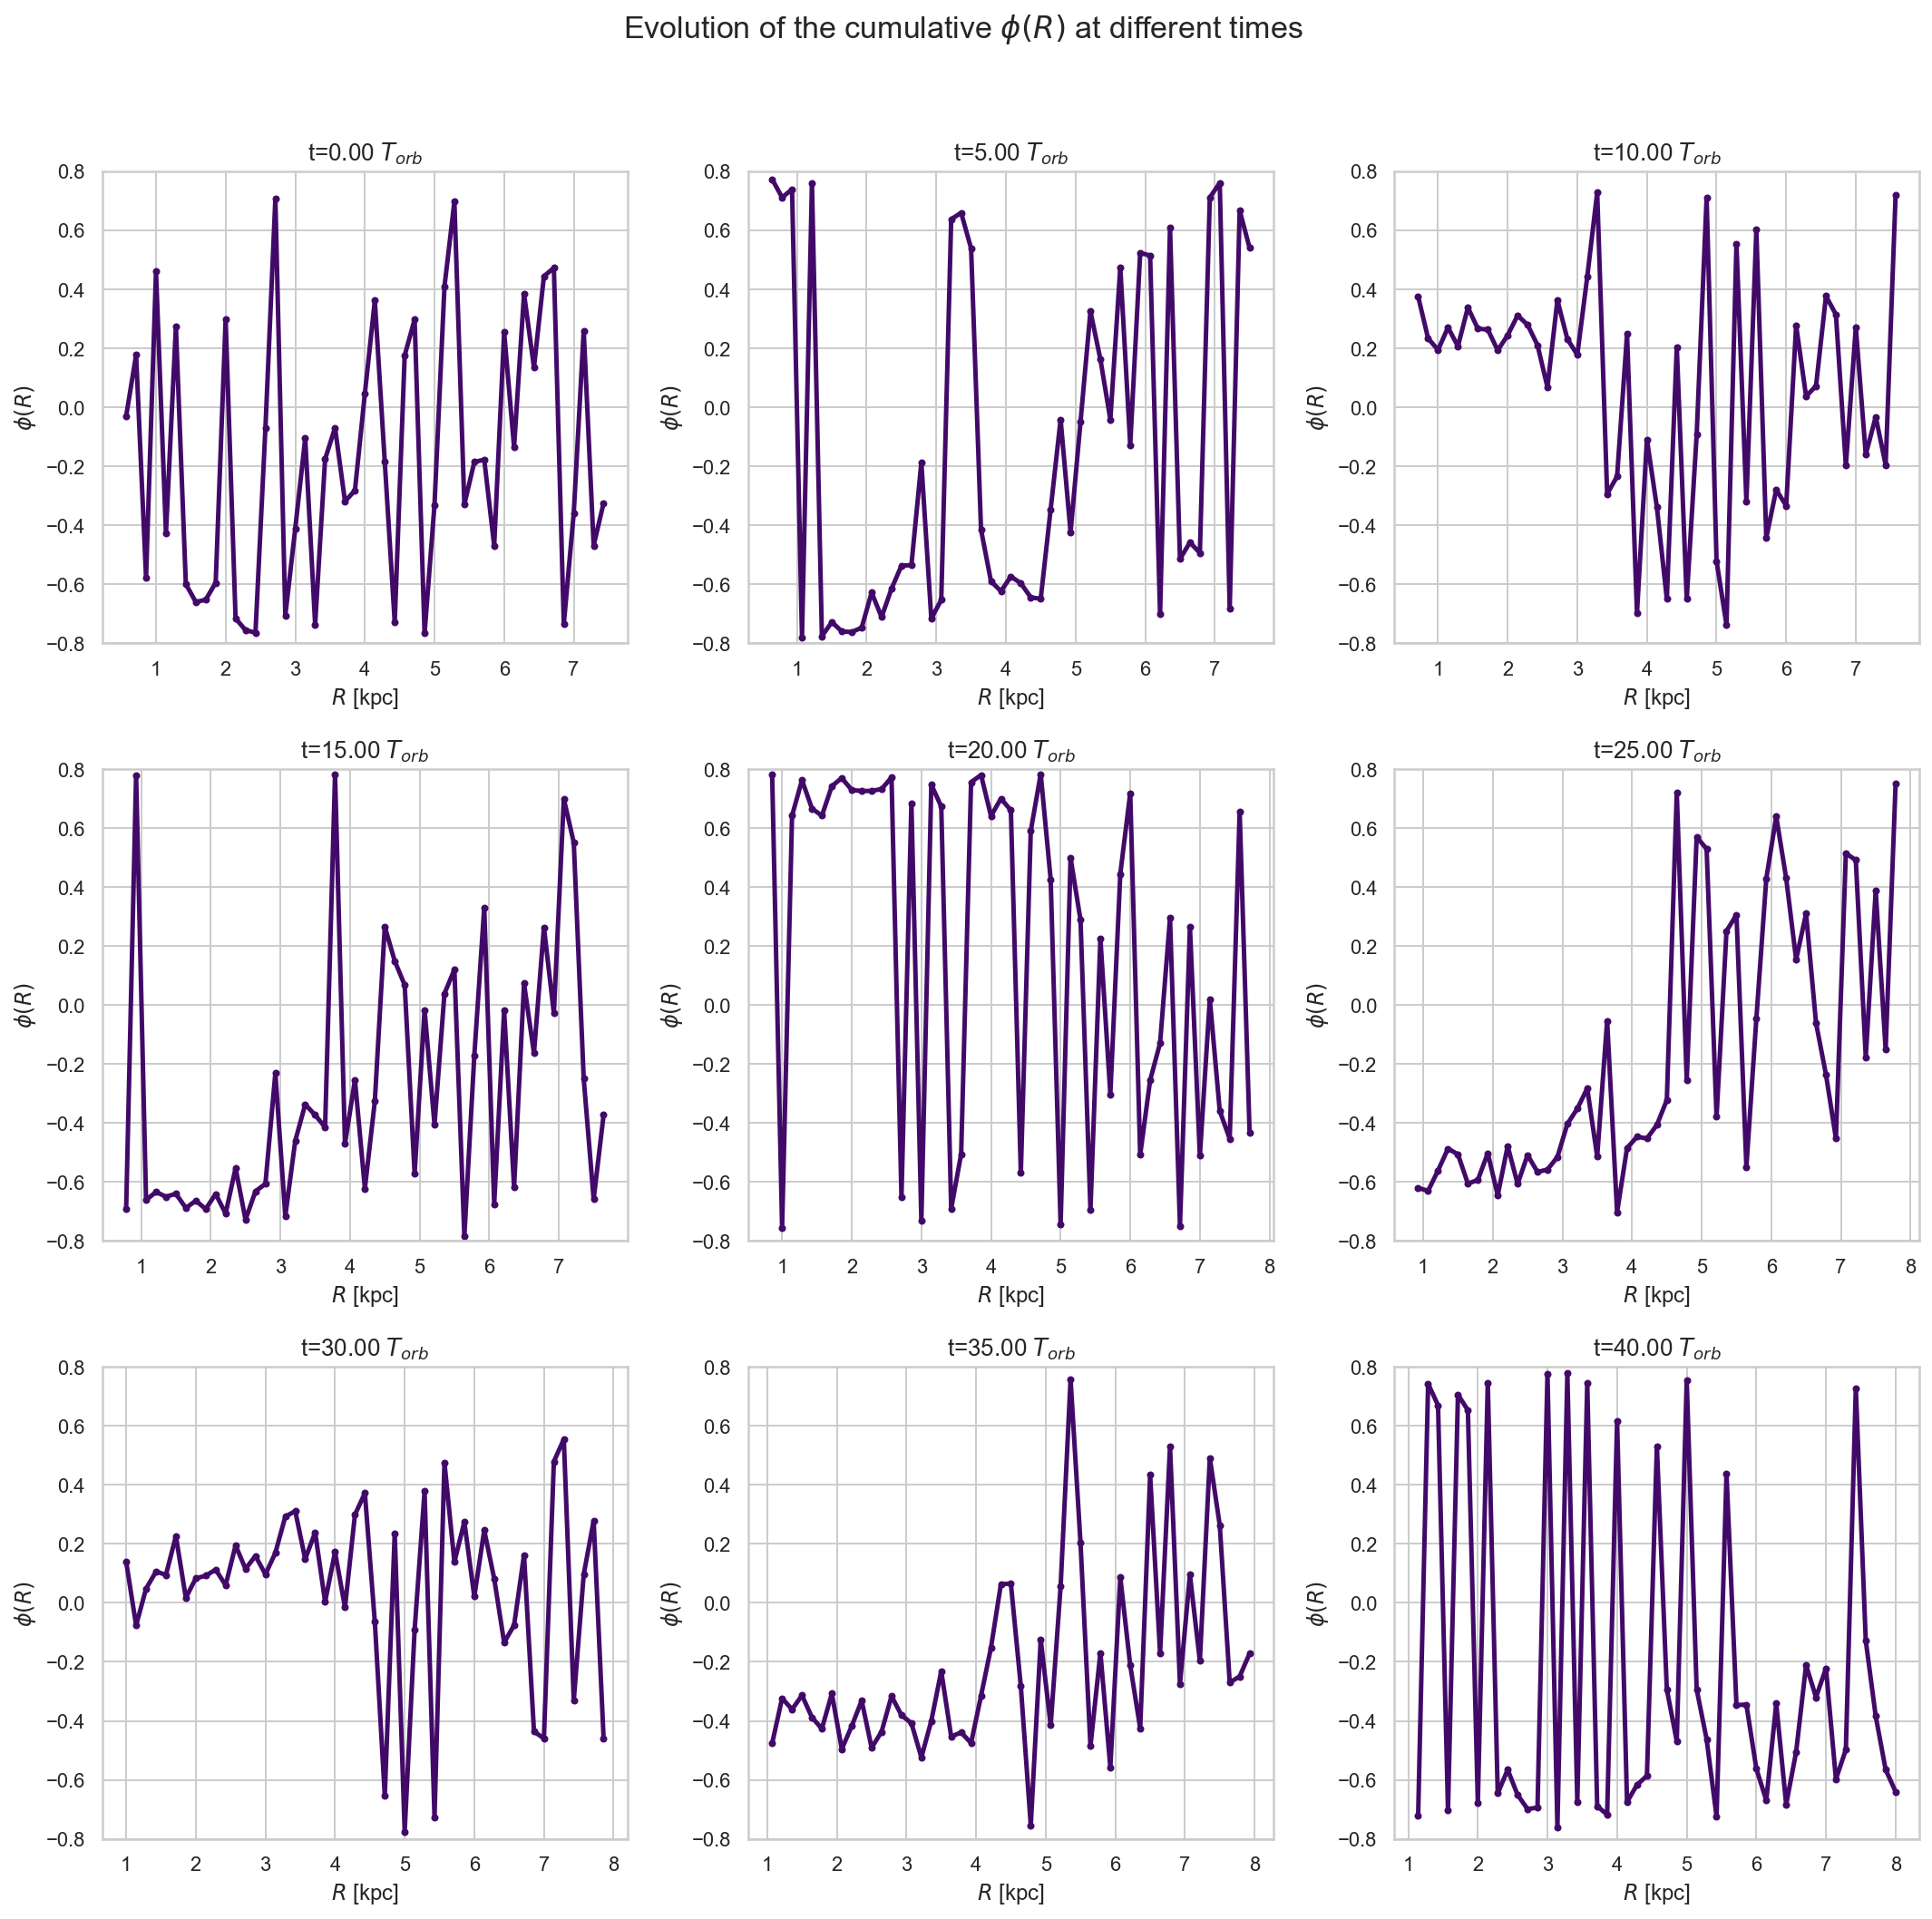

In [43]:
# Set Seaborn style
sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 3, figsize=(15, 15), tight_layout=True)

l = 10
time_array = np.linspace(0, len(t_s) - 1, 9, dtype=int)

t_dyn_units = t_s / T

for i, ax in zip(range(0, len(time_array)), axes.flatten()):
    ax.plot((R_max + (i+1) * step/2)[:-1], phi_r_t_diff[i], c=plt.cm.inferno(0.2), linewidth=2.5, marker='o', markersize=3, label='$\phi(R)$')
    
    ax.set_title(f't={(t_s[time_array[i]] / T):.2f} $T_{{orb}}$', fontsize=13)
    ax.set_xlabel('$R$ [kpc]', fontsize=12)
    ax.set_ylabel('$\phi(R)$', fontsize=12)
    #ax.legend(loc='upper right', fontsize='medium')
    ax.set_ylim(-0.8, 0.8)

# Adjust layout and add a title
fig.suptitle('Evolution of the cumulative $\phi(R)$ at different times', fontsize=17)

# Adjust spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

### Finding the constant behavior

I here decided to use a delta array evaluated between consecutive terms and then take only the even components (avoiding any possible correlation). Then taking as a reference for the deltas $0.5$ as a threshold, I used it to produce the estimate of the bar length.

In [84]:
delta_phi=np.array(phi_r_t_diff)[:, :-1]-np.array(phi_r_t_diff)[:, 1:]
delta_phi = delta_phi[:, ::2]

In [85]:
delta_phi.shape

(9, 24)

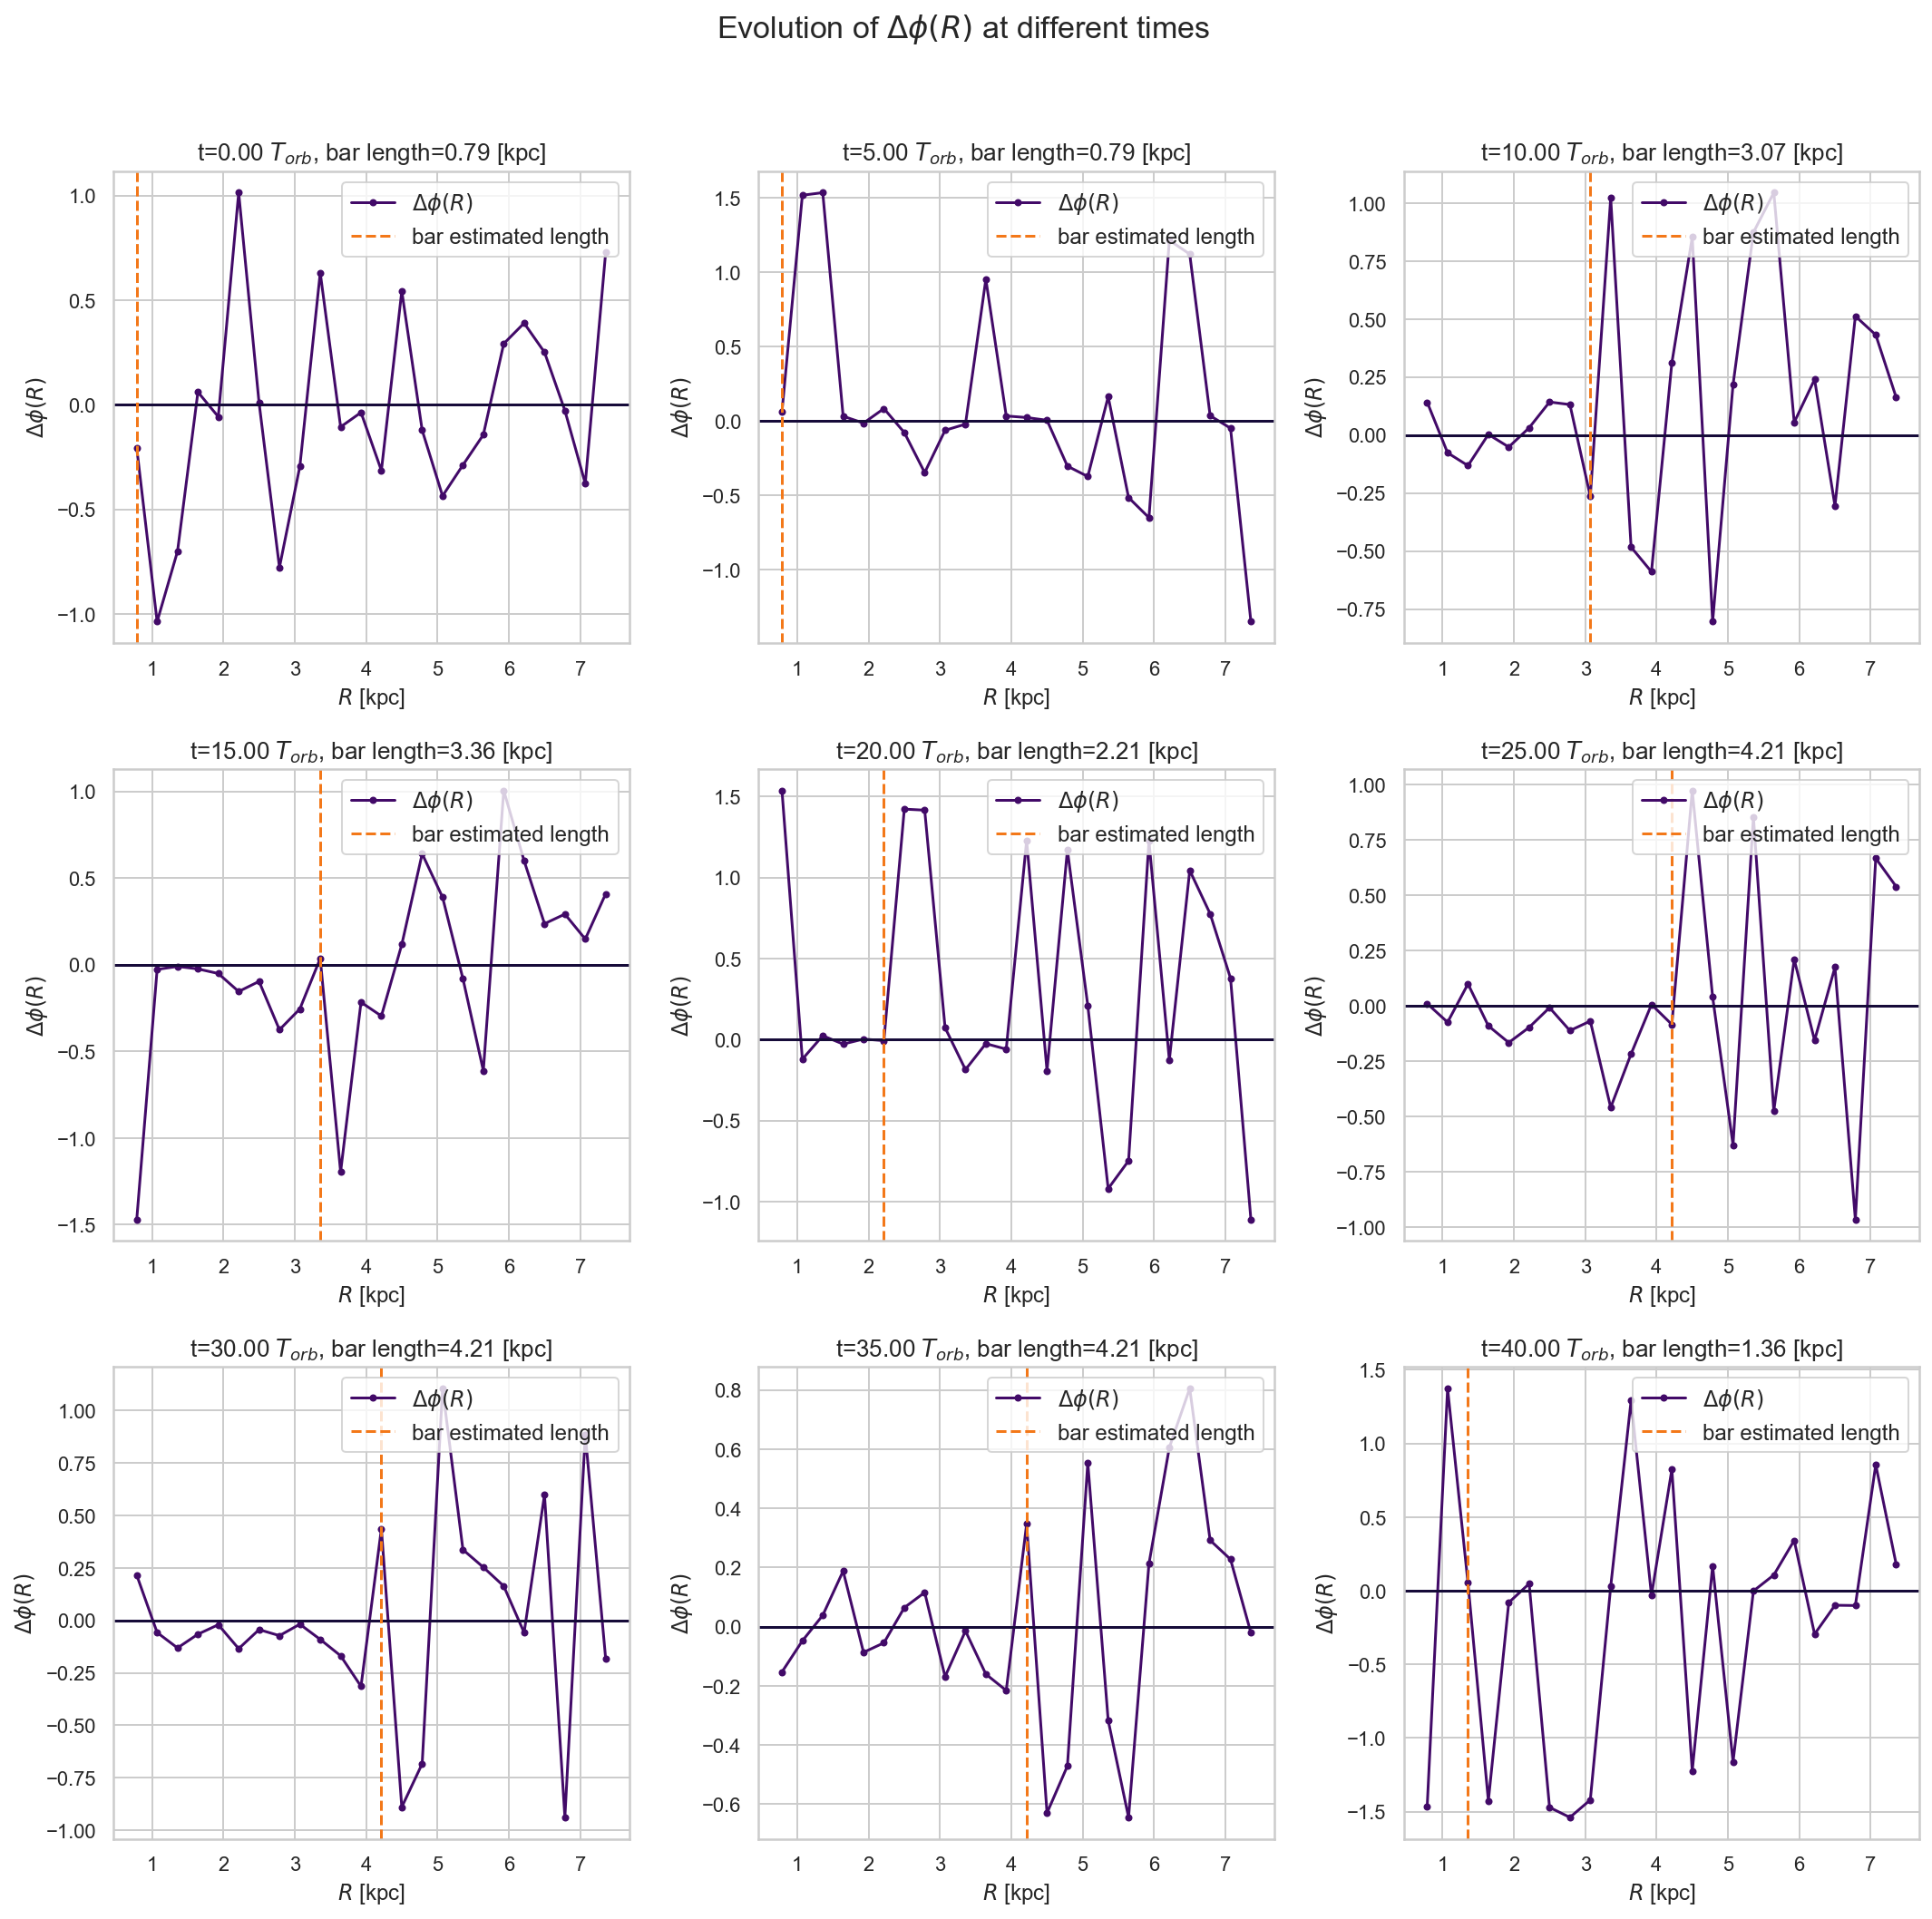

In [101]:
# Set Seaborn style
sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 3, figsize=(15, 15), tight_layout=True)

l = 10
time_array = np.linspace(0, len(t_s) - 1, 9, dtype=int)

t_dyn_units = t_s / T

for i, ax in zip(range(0, len(time_array)), axes.flatten()):
    indexes = np.where(np.abs(delta_phi[i, :]) < 0.5)[0]

    for k, j in zip(indexes, range(1, len(indexes))):
        if k + 1 != indexes[j]:
            treshold = k
            break

    ax.plot(
        (R_max)[::2][1:], #  + (i + 1) * step / 2
        delta_phi[i, :],
        c=sns.color_palette("inferno", as_cmap=True)(0.2),
        linewidth=1.5,
        marker='o',
        markersize=3,
        label='$\Delta\\phi(R)$',
    )
    ax.axhline(y=0, c=sns.color_palette("inferno", as_cmap=True)(0.1))
    ax.axvline(
        x=(R_max)[::2][1:][treshold],
        c=sns.color_palette("inferno", as_cmap=True)(0.7),
        label='bar estimated length',
        linestyle='--',
    )
    ax.set_title(
        f't={(t_s[time_array[i]] / T):.2f} $T_{{orb}}$, bar length={(R_max)[::2][1:][treshold]:.2f} [kpc]',
        fontsize=13,
    )
    ax.set_xlabel('$R$ [kpc]', fontsize=12)
    ax.set_ylabel('$\Delta\\phi(R)$', fontsize=12)
    ax.legend(loc='upper right', fontsize='medium')

# Adjust layout and add a title
fig.suptitle('Evolution of $\Delta\\phi(R)$ at different times', fontsize=17)

# Adjust spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('evolution-length.pdf', bbox_inches='tight')


plt.show()

---

### Bar length distribution:

Not sure whtther this might be a good way of displaying the results, but I here report my attempt to build up a distribution of bar lengths extracted over time, with the specific intent to report the median as the final result, with an associated uncertainty given by the percentiles ($1 \sigma$).

In [102]:
phi_total = []

for i in range(0, len(t_s)):

    phi_total.append(phi_bar_r(i, R_j_t[:, i], R_max, m_s[:, i], theta_j_t[:, i]))

In [107]:
delta_phi_total=np.array(phi_total)[:, :-1]-np.array(phi_total)[:, 1:]
delta_phi_total = delta_phi_total[:, ::2]

In [108]:
delta_phi_total.shape

(1001, 24)

In [109]:
bar_lengths = []

for i in range(0, len(t_s)):

    indexes = np.where(np.abs(delta_phi_total[i, :]) < 0.5)[0]
    
    for k,j in zip(indexes, range(1, len(indexes))): 
        
        if k+1 != indexes[j]:
                   
            treshold = k
            break
                
    bar_lengths.append((R_max)[::2][1:][treshold])

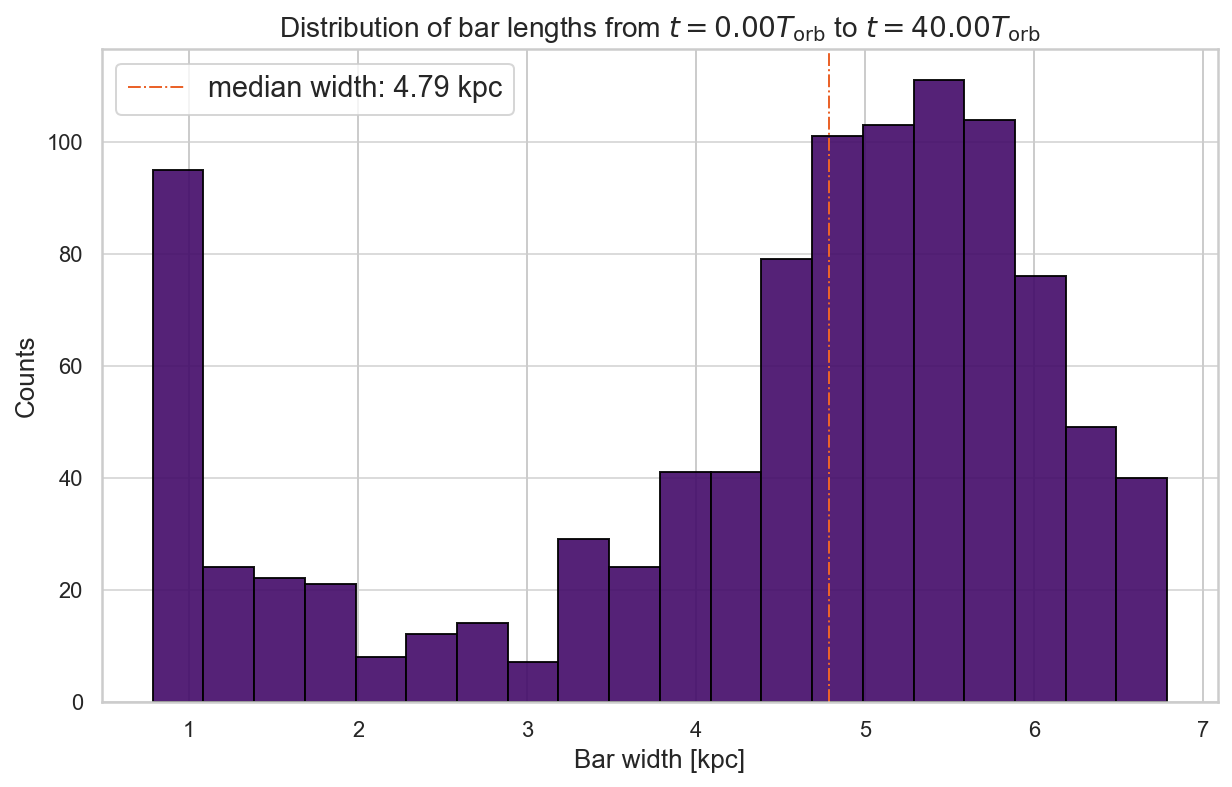

In [112]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

# Assuming bar_lengths is your data
plt.hist(bar_lengths, bins=20, color=plt.cm.inferno(0.2), edgecolor='black', linewidth=1, alpha=0.9)
plt.axvline(x=np.median(bar_lengths), color=plt.cm.inferno(0.65), linewidth=1, alpha=1, label=f'median width: {np.median(bar_lengths):.2f} kpc', linestyle='-.')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='-', alpha=0.7)

plt.xlabel("Bar width [kpc]", fontsize=13)
plt.ylabel("Counts", fontsize=13)
plt.title(f"Distribution of bar lengths from $t={t_s[0]/T:.2f} T_{{\mathrm{{orb}}}}$ to $t={t_s[1000]/T:.2f} T_{{\mathrm{{orb}}}}$", fontsize=14)
plt.legend(fontsize='large')
plt.savefig('bar_distribution.pdf')
plt.show()

In [113]:
print('5%', np.percentile(bar_lengths, 34.1))
print('95%',np.percentile(bar_lengths, 65.9))

5% 4.5
95% 5.357142857142857


---

### Angles distribution in time

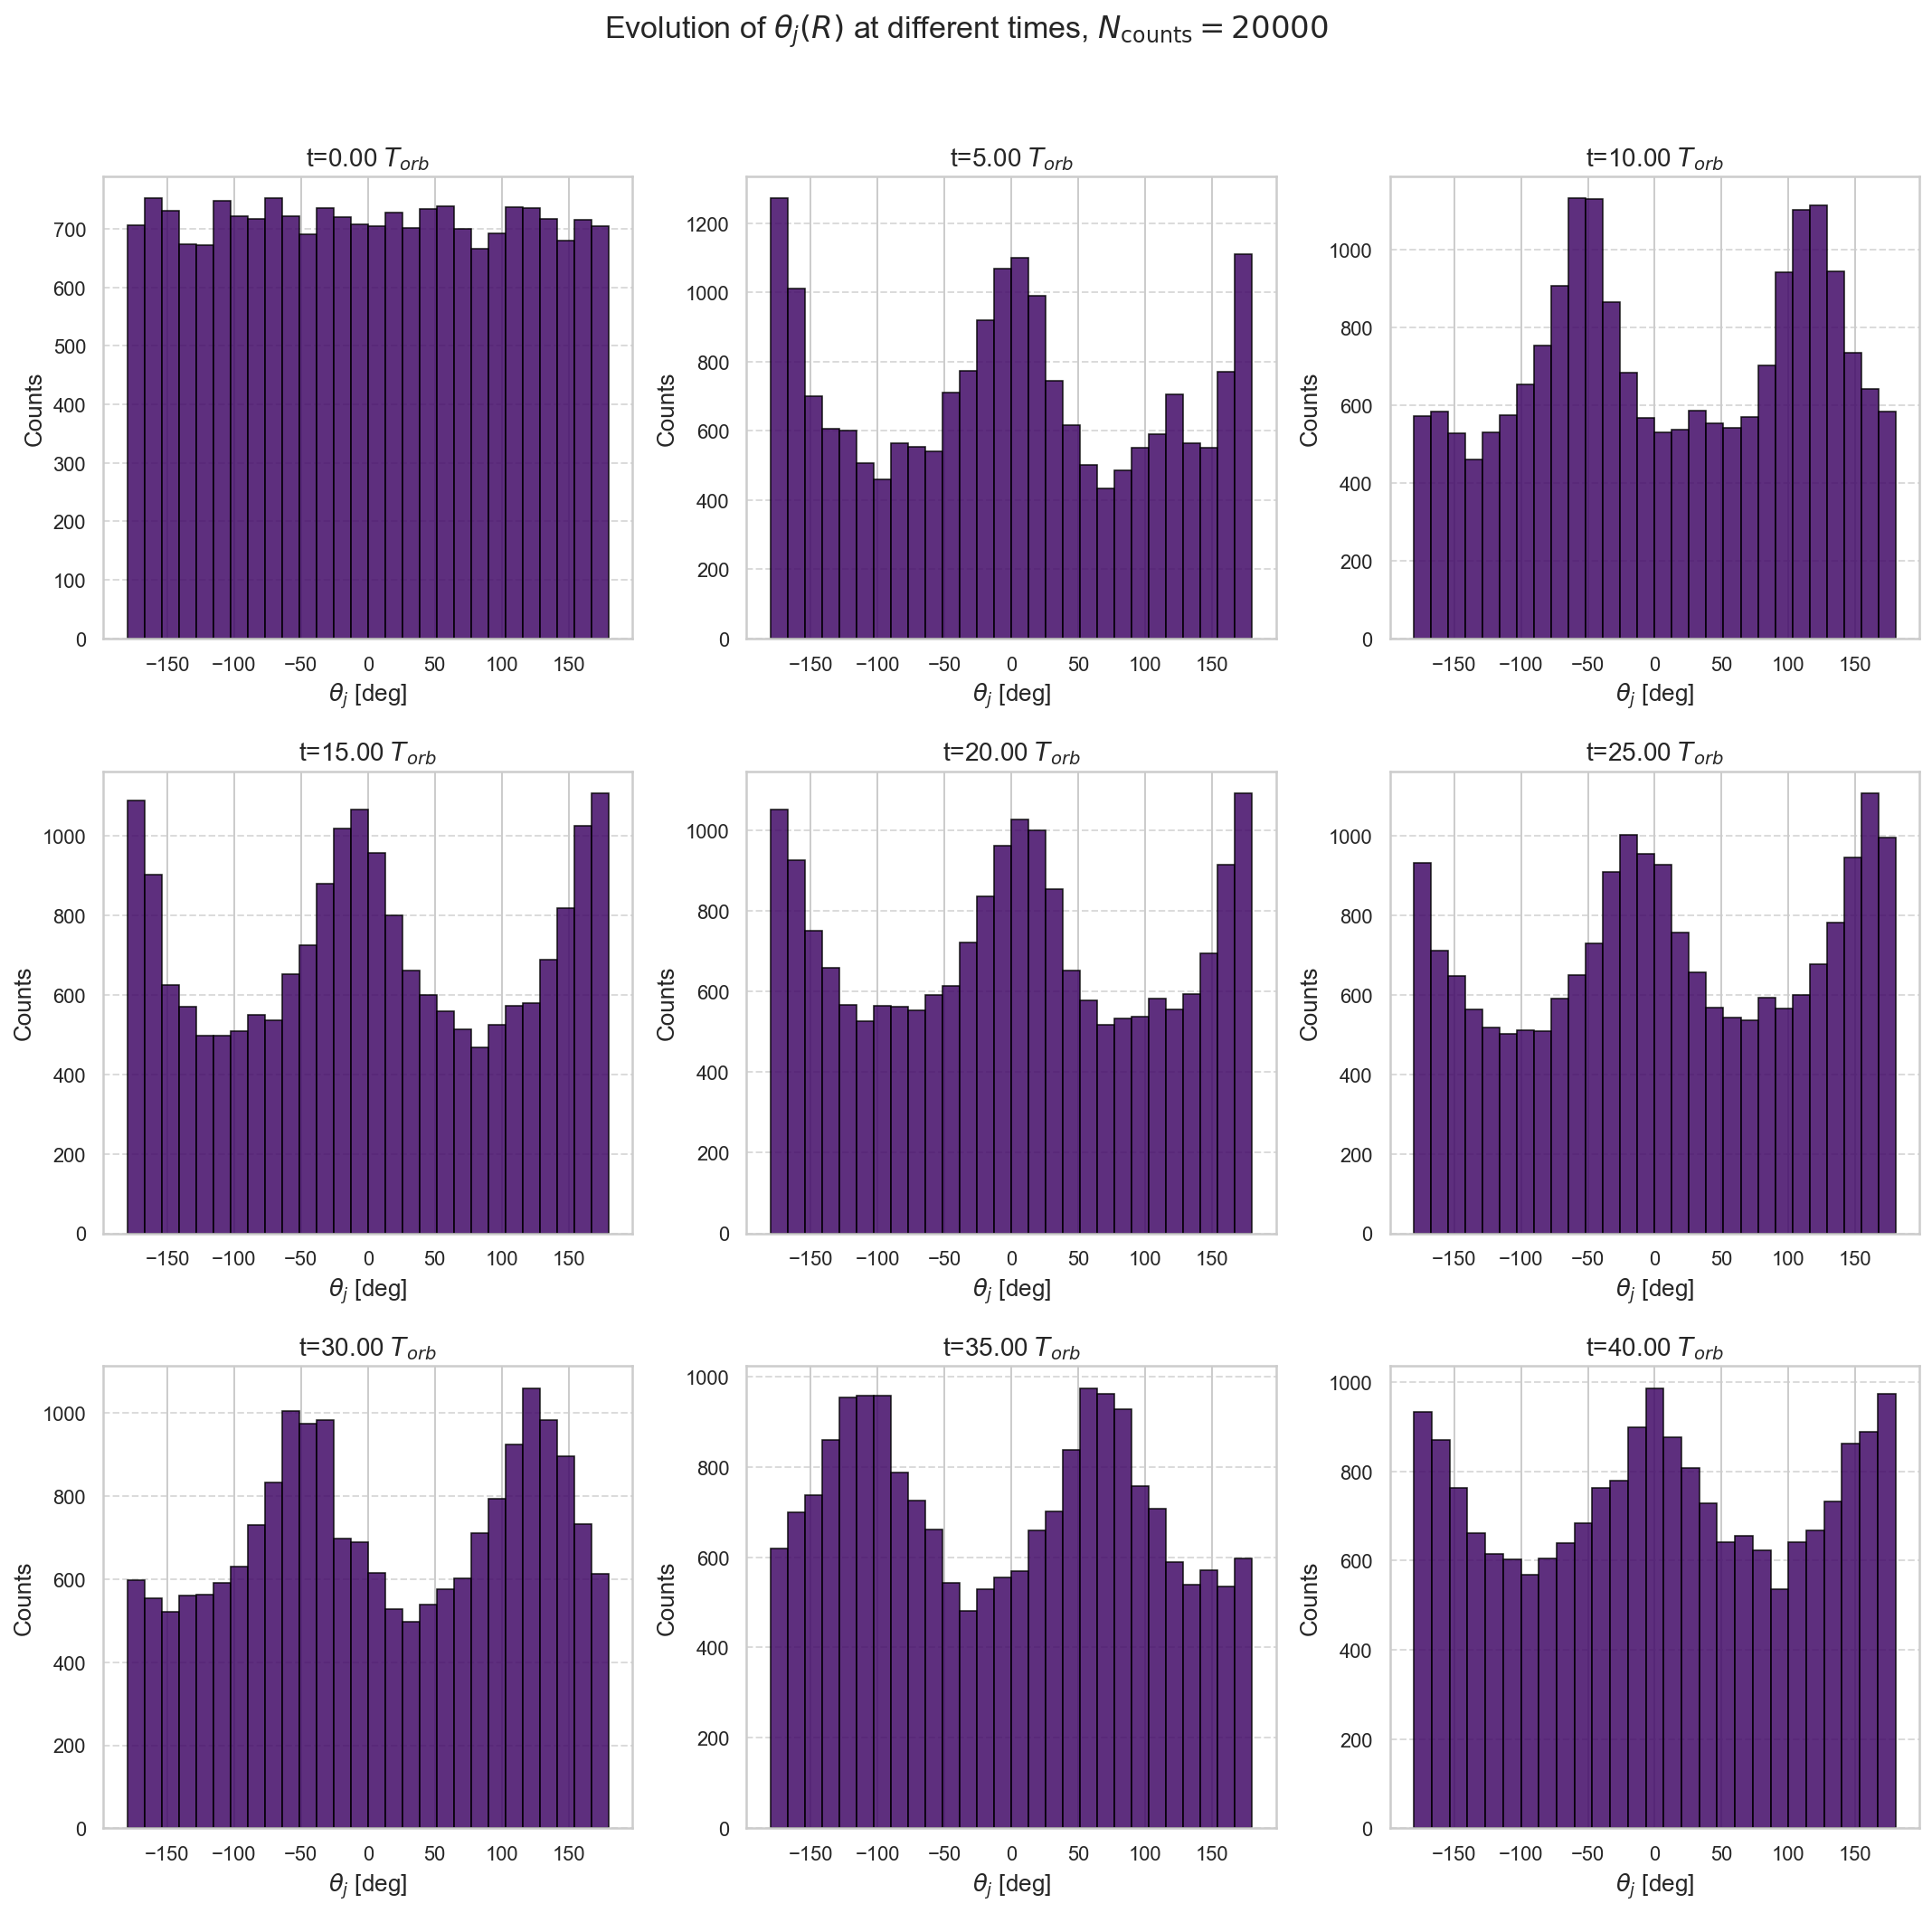

In [53]:
# Set Seaborn style
sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 3, figsize=(15, 15), tight_layout=True)

l = 10
time_array = np.linspace(0, len(t_s) - 1, 9, dtype=int)

t_dyn_units = t_s / T

for i, ax in zip(range(0, len(time_array)), axes.flatten()):
    
    # Use 'auto' option for bins to automatically determine the number of bins
    ax.hist(theta_j_t_selected[:, i] * 180 / np.pi, bins='auto', color=plt.cm.inferno(0.2), alpha=0.85, edgecolor='black', linewidth=0.8)
    
    # Add grid lines for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    ax.set_xlabel(r'$\theta_j$ [deg]', fontsize=13)
    ax.set_ylabel('Counts', fontsize=13)
    
    # Adjust the title for better spacing
    ax.set_title(f't={(t_s[time_array[i]] / T):.2f} $T_{{orb}}$', fontsize=14)

    
# Adjust layout and add a title
fig.suptitle(r'Evolution of $\theta_j(R)$ at different times, $N_{\mathrm{counts}}=20000$', fontsize=17)

# Adjust spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('angles-time.pdf')

plt.show()

The size of the bar should be extracted from the following considerations: 

- the angle represented is a sort of $\textit{mean}$, which could be paired to the calculation of the distribution of $\theta_j$ for each frame (where you can clearly see a bar form);

- the bar extention itself will be the radial extention for which we have approximately constant angles $\Phi(R)$, then abruptly changing. 